# Предсказание стартапов

## Описание 

### Цель - разработать модель для предсказания успешности стартапа (закроется или нет).

### Задачи: 
1. Регистрация на Kaggle
2. Загрузка и ознакомление с данными.
3. Предварительная обработка.
4. Полноценный разведочный анализ.
5. Разработка новых синтетических признаков. 6. Проверка на мультиколлинеарность, 7. Отбор финального набора обучающих признаков.
8. Выбор и обучение моделей.
9. Итоговая оценка качества предсказания лучшей модели.
10. Анализ важности ее признаков.
11. Подготовка отчета по исследованию.

### Исходные данные.
Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'
    • kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
    • kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
    • kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
    • name - идентификатор (название) стартапа в тестовом наборе.
    • status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].
    
Описание полей данных
name - Название стартапа
category_list - Список категорий, к которым относится стартап
funding_total_usd - Общая сумма финансирования в USD
status - Статус стартапа (закрыт или действующий)
country_code - Код страны
state_code - Код штата
region - Регион
city - Город
funding_rounds - Количество раундов финансирования
founded_at - Дата основания
first_funding_at - Дата первого раунда финансирования
last_funding_at - Дата последнего раунда финансирования
closed_at - Дата закрытия стартапа (если применимо)
lifetime - Время существования стартапа в днях

## Загрузка библиотек, данных и знакомство с данными.


In [1]:
!pip install numpy>=0.2,<0.3 --upgrade
!pip install --upgrade scikit-learn
!pip install numba --upgrade
!pip install matplotlib==3.7.3 --upgrade
!pip install shap --upgrade -q
!pip install phik
!pip install imbalanced-learn -q
#!pip install pandas --upgrade #может быть не надо инициализировать

/bin/bash: 0.3: No such file or directory


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (14,12)
from sklearn.preprocessing import LabelEncoder
import phik
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import shap
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
a0 = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')

In [5]:
a0

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,closed
13123,AdWill,operating


In [6]:
a0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB


`Первая таблица:` *13125 строк, два столбца объектного типа. Нулевых данных нет. Данные представляют собой целевую переменную для тестовых данных. В таком же виде необходимо представить прогноз.*

In [7]:
a_test = pd.read_csv('kaggle_startups_test_28062024.csv')
a_test

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267
13121,GlobaTrek,Software,NaN,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386


In [8]:
a_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


`Вторая таблица: `*Данные являются тестовыми для будущей модели. Здесь также 13125 строк. 10 столбцов объектного, целочисленного и вещественного типов. БольшАя часть данных пропущена, особенно в "Общая сумма финансирования" (около 3 тыс пропусков). В столбце Код шатата содержатся как строковые значения, так и числа.*

In [9]:
a_tren = pd.read_csv('kaggle_startups_train_28062024.csv')
a_tren

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaN
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaN
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaN


In [10]:
a_tren.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


`Третья таблица:`*Тренировочные данные. Здесь 52516 строк, 12 столбцов.  Типы объектного, целочисленного и вещественного типов. БольшАя часть данных пропущена, особенно в "Общая сумма финансирования" (более 10 тыс. строк). Есть даже пропуск в навзании стартапа. В столбце Код шатата содержатся как строковые значения, так и числа. Этот датасет отличается от тестового датасета не только столбцом "Статус стартапа", но и "Дата закрытия стартапа", а также "Время жизни стартапа".* 

## Предварительная обработка.

### Тренировочная таблица.

#### Проверка дубликатов, уникальных значений, пропусков.

In [11]:
def prep(df): #создадим функцию для знакомства и предобработки данных
    print(df.info())
    print("Количество строк таблицы до удаления дубликатов: ", df.shape[0])
    df = df.drop_duplicates().reset_index(drop=True)
    print("Размер таблицы после удаления дубликатов: ", df.shape)
    print ("Количество дубликатов после их удаления: ", df.duplicated().sum())
    print('Уникальные значения в столбцах:')
    i=0
    for i in df.columns:
        try:
            print(f"  В столбце  {i}  такие уникальные значения:")
            print(df[i].sort_values().unique())
        except:
            print ('Похоже, ошибка в типе данных в столбце', i)
        print()    
    j=0
    for j in df.columns:
        print (f"Доля пропусков в столбце {j} - {round(df[j].isna().sum()*100/df.shape[0],2)} %")
      
    return df.sample(5)

In [12]:
prep(a_tren)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None
Количество строк таблицы до удаления дубликатов:  52516
Размер таблицы после удаления дубликатов:  (525

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3413,MobbWorld Game Studios Philippines,Facebook Applications|Games|iPhone|Twitter App...,100000.0,operating,PHL,A1,PHL - Other,Angeles City,1,2009-06-05,2009-08-01,2009-08-01,NaN
6118,Plum - The light switch reimagined,Hardware + Software|Home Automation|Internet o...,6957000.0,operating,USA,TX,Austin,Austin,6,2012-01-01,2012-08-01,2015-08-04,NaN
18929,Zubie,Hardware + Software,19869969.0,operating,USA,SC,"Charleston, South Carolina",Sullivans Island,4,2012-05-01,2012-05-01,2015-06-05,NaN
5565,Global Animationz,Medical,NaN,operating,USA,ND,Fargo,West Fargo,1,2013-01-01,2014-09-09,2014-09-09,NaN
24512,Lagoon,Apps,20000.0,operating,USA,OH,Cincinnati,Cincinnati,1,2014-01-01,2014-07-18,2014-07-18,NaN


`Вывод:` На первый взгляд дубликатов нет. Проверим неявные дубликаты. Стоит привести все строковые названия к строкам с нижним регистром и снова проверить строки на полные дубликаты.

Доли пропусков значительные, удалять нельзя. Самые важные признаки: категория, страна, сумма финансирования, количество раундов финансирования. Там, где нет страны, её даже невозможно восстановить, т.к. нет никаких данных о территории принадлежности. Также есть пропуск в названии стартапа.

В Списке категорий, сумме финансирования также много пропусков.

Предлагаю удалить строки в которых нет данных по этим трем признакам.

Список категорий слишком длинный из-за того, что часть стартапов отнесены к нескольким категориям. Строки из набора категорий воспринимаются как отдельная категория. Исправим это, добавив столбец, оставив из списка категорий только одну - первую.

##### Работа с пропусками.

###### Устранение пропусков в столбцах, где отсутствуют три важных признака.

In [13]:
a = a_tren[(a_tren['country_code'].isna() == True) 
           & (a_tren['category_list'].isna() == True) 
           & (a_tren['funding_total_usd'].isna() == True)]
a.shape

(884, 13)

884 строки. Объем данных от удаления незначительно пострадает.

In [14]:
ind = a.index
ind

Int64Index([   16,    24,    64,    78,   155,   158,   323,   348,   394,
              438,
            ...
            51965, 52023, 52081, 52082, 52175, 52327, 52377, 52394, 52404,
            52419],
           dtype='int64', length=884)

In [15]:
a_train = a_tren.drop(axis=0,index=ind)
print (f'При удалении строк с отсутствующими важными признаками датафрэйм уменьшился на {a_tren.shape[0] - a_train.shape[0]} строк')

При удалении строк с отсутствующими важными признаками датафрэйм уменьшился на 884 строк


In [16]:
a_train.shape

(51632, 13)

`Вывод:` *Удалили 884 строки, содержащие нули в коде страны, категории, объеме финансирования. Данные уменьшились с 52516 до 51632 строк. Такое уменьшение не повредит данным.*

###### Заполнение пропуска в столбце funding_total_usd нулем.

In [17]:
a_train['funding_total_usd'] = a_train['funding_total_usd'].fillna(0)
print('Теперь пропусков в Общей сумме финансирования - ', a_train['funding_total_usd'].isna().sum())

Теперь пропусков в Общей сумме финансирования -  0


##### Удаление строки со стартапом без названия

In [18]:
k1 = a_train.shape #зафиксировали размер датафрэйма перед удалением строки без названия стартапа
train = a_train[a_train['name'].isna() == False]
print(f'Удалено {k1[0] - train.shape[0]} строк')

Удалено 1 строк


##### Работа с неявными дубликатами. 

Приводим строковые данные к нижнему регистру.

In [19]:
l = ['name', 'category_list', 'region', 'city']
for k in l:
    train[k] = train[k].str.lower()

train.sample(5)

/tmp/ipykernel_102/2196384757.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[k] = train[k].str.lower()


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
42228,spacebar,audio|iphone|mobile|music|video streaming,0.0,operating,USA,CA,sf bay area,san francisco,1,2012-06-28,2012-12-18,2012-12-18,NaN
39586,pay-me,mobile payments,1000000.0,operating,RUS,48,moscow,moscow,1,2012-05-01,2012-01-01,2012-01-01,NaN
47321,topia technology,mobile|software,1053098.0,operating,USA,WA,seattle,tacoma,1,1999-01-01,2015-05-06,2015-05-06,NaN
44231,ovonyx,semiconductors,303750.0,operating,USA,MI,detroit,rochester hills,1,1999-01-01,2010-02-08,2010-02-08,NaN
37271,fluentify,education|language learning|marketplaces,410000.0,operating,GBR,H9,london,london,1,2013-02-01,2014-03-31,2014-03-31,NaN


In [20]:
k2 = train.shape[0]
train = train.drop_duplicates().reset_index(drop=True)
print("Удалено дубликатов", k2 - train.shape[0])

Удалено дубликатов 0


Проверим дубликаты в связке важных столбцов: название, категория, страна.

In [21]:
k2 = train.shape[0]
train[['name', 'category_list', 'country_code']].duplicated().sum()
#print("Удалено дубликатов", k2 - train_dup.shape[0])

0

`Вывод:` *Значит, неявных дубликатов не было.*

#### Перевод столбцов с датами в нужный тип.

In [22]:
l2 = ['founded_at', 'first_funding_at', 'last_funding_at','closed_at']
i=0
for i in l2:
    train[i] = pd.to_datetime(train[i], format='%Y-%m-%d')
train.info()
display(train.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51631 entries, 0 to 51630
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               51631 non-null  object        
 1   category_list      50050 non-null  object        
 2   funding_total_usd  51631 non-null  float64       
 3   status             51631 non-null  object        
 4   country_code       47013 non-null  object        
 5   state_code         45752 non-null  object        
 6   region             46156 non-null  object        
 7   city               46156 non-null  object        
 8   funding_rounds     51631 non-null  int64         
 9   founded_at         51631 non-null  datetime64[ns]
 10  first_funding_at   51631 non-null  datetime64[ns]
 11  last_funding_at    51631 non-null  datetime64[ns]
 12  closed_at          4607 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
6743,tira wireless,software,23500000.0,closed,CAN,ON,toronto,toronto,4,2001-01-01,2002-10-16,2007-07-09,2009-01-08
1187,artency.com,art|e-commerce|jewelry|lifestyle,0.0,operating,ESP,29,madrid,madrid,1,2012-07-01,2012-07-01,2012-07-01,NaT
42851,health evillages,biotechnology,58000.0,operating,USA,MA,boston,reading,1,2011-01-01,2013-08-27,2013-08-27,NaT
5825,tacit knowledge,consulting|e-commerce|retail|shopping|software...,7000000.0,operating,USA,CA,sf bay area,san francisco,1,2002-01-01,2004-04-20,2004-04-20,NaT
42541,compass,NaN,3000000.0,operating,GBR,N7,london,guildford,1,1980-01-01,2014-10-27,2014-10-27,NaT


Столбцы с датой переведены из строчного типа в тип даты.

Для анализа понадобится год раунда. Добавим дополнительные столбцы, полученные из first_funding_at и last_funding_at, но содержащие только годы раундов финансирования.

In [23]:
train.loc[:, 'first_funding_at_year'] = train.loc[:, 'first_funding_at'].dt.year
train.loc[:, 'last_funding_at_year'] = train.loc[:, 'last_funding_at'].dt.year
train.sample(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,first_funding_at_year,last_funding_at_year
6270,eyeglass24,e-commerce,0.0,operating,DEU,2,munich,munich,1,2012-08-02,2013-09-01,2013-09-01,NaT,2013,2013
39099,wattvision,hardware + software,0.0,operating,USA,NJ,newark,princeton,1,2009-01-01,2009-01-01,2009-01-01,NaT,2009,2009
3514,gc lifeline,software,0.0,operating,CAN,AB,edmonton,edmonton,1,2015-02-17,2015-04-29,2015-04-29,NaT,2015,2015
23579,medical datasoft international,electronic health records|health care informat...,280440.0,operating,USA,CA,sacramento,roseville,1,2005-10-27,2006-06-21,2006-06-21,NaT,2006,2006
11332,ez2companies,internet|portals|services,10000000.0,closed,USA,FL,miami,miami,1,2004-08-31,2005-08-05,2005-08-05,2007-06-22,2005,2005


`Вывод:` *столбцы с датами приняли тип дат. Созданы дополнительные столбцы, содержащие годы раундов.*

#### Добавление столбца lifetime в тренировочные данные



Время жизни стартапа равно разнице между датой выгрузи и датой открытия, или датой закрытия и датой открытия. По этому принципу в тренировочные данные добавим дополнительный признак.

In [24]:
a = train.query('status == "operating"')

b = train.query('status == "closed"')
b['lifetime'] = b['closed_at']-b['founded_at']
b.head()


/tmp/ipykernel_102/29818929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['lifetime'] = b['closed_at']-b['founded_at']


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,first_funding_at_year,last_funding_at_year,lifetime
12,iberic premium,NaN,107239.0,closed,NaN,NaN,NaN,NaN,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10,2014,2014,714 days
22,vputi,consumers,50000.0,closed,RUS,91,rus - other,krasnoyarsk,1,2012-04-26,2013-03-08,2013-03-08,2014-09-04,2013,2013,861 days
27,newworld communications,technology,150000000.0,closed,NaN,NaN,NaN,NaN,1,1999-05-04,2000-06-01,2000-06-01,2001-12-28,2000,2000,969 days
51,domosite,home owners|internet|private social networking,700000.0,closed,NaN,NaN,NaN,NaN,1,2011-07-12,2012-10-01,2012-10-01,2014-04-26,2012,2012,1019 days
79,efectivox,finance|services|transportation,6192900.0,closed,ESP,29,leganes,leganés,1,2010-07-01,2011-02-26,2011-02-26,2012-02-26,2011,2011,605 days


In [25]:
b.info() #закрытые компании

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4607 entries, 12 to 51600
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   name                   4607 non-null   object         
 1   category_list          4187 non-null   object         
 2   funding_total_usd      4607 non-null   float64        
 3   status                 4607 non-null   object         
 4   country_code           3630 non-null   object         
 5   state_code             3522 non-null   object         
 6   region                 3549 non-null   object         
 7   city                   3549 non-null   object         
 8   funding_rounds         4607 non-null   int64          
 9   founded_at             4607 non-null   datetime64[ns] 
 10  first_funding_at       4607 non-null   datetime64[ns] 
 11  last_funding_at        4607 non-null   datetime64[ns] 
 12  closed_at              4607 non-null   datetim

In [26]:
b['lifetime'] = b['lifetime'].dt.days

/tmp/ipykernel_102/421838094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['lifetime'] = b['lifetime'].dt.days


In [27]:
b.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,first_funding_at_year,last_funding_at_year,lifetime
12,iberic premium,NaN,107239.0,closed,NaN,NaN,NaN,NaN,1,2013-07-26,2014-06-01,2014-06-01,2015-07-10,2014,2014,714
22,vputi,consumers,50000.0,closed,RUS,91,rus - other,krasnoyarsk,1,2012-04-26,2013-03-08,2013-03-08,2014-09-04,2013,2013,861
27,newworld communications,technology,150000000.0,closed,NaN,NaN,NaN,NaN,1,1999-05-04,2000-06-01,2000-06-01,2001-12-28,2000,2000,969
51,domosite,home owners|internet|private social networking,700000.0,closed,NaN,NaN,NaN,NaN,1,2011-07-12,2012-10-01,2012-10-01,2014-04-26,2012,2012,1019
79,efectivox,finance|services|transportation,6192900.0,closed,ESP,29,leganes,leganés,1,2010-07-01,2011-02-26,2011-02-26,2012-02-26,2011,2011,605


Для открытых компаний срок жизни.

In [28]:
def liftime(d):
    start_date = datetime.strptime("2018-01-01", "%Y-%m-%d")
    n = start_date - d
    return n
    


In [29]:
a.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,first_funding_at_year,last_funding_at_year
0,lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,zurich,zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2011,2014
1,earlens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,sf bay area,redwood city,4,2005-01-01,2010-05-04,2014-02-25,NaT,2010,2014
2,reviva pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,sf bay area,san jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,2012,2014
3,sancilio and company,health care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,2011,2014
4,wiretough cylinders,manufacturing,0.0,operating,USA,VA,va - other,bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,2012,2012


In [30]:
a['lifetime'] = a['founded_at'].apply(liftime)
a['lifetime'] = a['lifetime'].dt.days
a.head()

/tmp/ipykernel_102/1388273387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['lifetime'] = a['founded_at'].apply(liftime)
/tmp/ipykernel_102/1388273387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['lifetime'] = a['lifetime'].dt.days


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,first_funding_at_year,last_funding_at_year,lifetime
0,lunchgate,online reservations|restaurants,828626.0,operating,CHE,25,zurich,zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,2011,2014,2998
1,earlens,manufacturing|medical|medical devices,42935019.0,operating,USA,CA,sf bay area,redwood city,4,2005-01-01,2010-05-04,2014-02-25,NaT,2010,2014,4748
2,reviva pharmaceuticals,biotechnology,35456381.0,operating,USA,CA,sf bay area,san jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,2012,2014,4383
3,sancilio and company,health care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,2011,2014,5114
4,wiretough cylinders,manufacturing,0.0,operating,USA,VA,va - other,bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,2012,2012,2791


In [31]:
res = pd.concat([a, b], ignore_index=True)
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51631 entries, 0 to 51630
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   51631 non-null  object        
 1   category_list          50050 non-null  object        
 2   funding_total_usd      51631 non-null  float64       
 3   status                 51631 non-null  object        
 4   country_code           47013 non-null  object        
 5   state_code             45752 non-null  object        
 6   region                 46156 non-null  object        
 7   city                   46156 non-null  object        
 8   funding_rounds         51631 non-null  int64         
 9   founded_at             51631 non-null  datetime64[ns]
 10  first_funding_at       51631 non-null  datetime64[ns]
 11  last_funding_at        51631 non-null  datetime64[ns]
 12  closed_at              4607 non-null   datetime64[ns]
 13  f

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51631 entries, 0 to 51630
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   51631 non-null  object        
 1   category_list          50050 non-null  object        
 2   funding_total_usd      51631 non-null  float64       
 3   status                 51631 non-null  object        
 4   country_code           47013 non-null  object        
 5   state_code             45752 non-null  object        
 6   region                 46156 non-null  object        
 7   city                   46156 non-null  object        
 8   funding_rounds         51631 non-null  int64         
 9   founded_at             51631 non-null  datetime64[ns]
 10  first_funding_at       51631 non-null  datetime64[ns]
 11  last_funding_at        51631 non-null  datetime64[ns]
 12  closed_at              4607 non-null   datetime64[ns]
 13  f

In [33]:
train=res

`Вывод:` *В тренировочные данные добавлен признак lifetime.*

#### Исправление столбца с категориями

In [34]:
train['category_list'].value_counts()

software                                                                                                         3207
biotechnology                                                                                                    2905
e-commerce                                                                                                       1064
mobile                                                                                                            920
clean technology                                                                                                  892
                                                                                                                 ... 
biotechnology|consumer goods|diabetes|health and wellness                                                           1
education|k-12 education|software                                                                                   1
data privacy|enterprise software|software               

In [35]:
def split0(d): #создана функция по отделению первого слова до вертикальной черты от строки
    try:
        result = d.split('|')[0]
        return result
    except:
        return d

In [36]:
train.loc[:,'category_list_cor'] = train['category_list'].apply(split0)
train.sample(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,first_funding_at_year,last_funding_at_year,lifetime,category_list_cor
28571,multipon networks,semiconductors,500000.0,operating,ISR,2,netanya,omez,1,2004-08-16,2006-08-02,2006-08-02,NaT,2006,2006,4886,semiconductors
2924,realtime games,fantasy sports|games|mobile games|real time|so...,0.0,operating,GBR,H9,london,london,1,2013-01-01,2013-09-30,2013-09-30,NaT,2013,2013,1826,fantasy sports
37584,spaceport.io,games,3000000.0,operating,USA,CA,sf bay area,burlingame,1,2011-04-29,2012-04-11,2012-04-11,NaT,2012,2012,2439,games
14250,pwc pure water corporation,manufacturing,0.0,operating,CAN,BC,delta,delta,1,2012-02-20,2013-10-03,2013-10-03,NaT,2013,2013,2142,manufacturing
2785,beach solutions,internet,3000000.0,operating,GBR,K7,london,reading,1,1998-01-01,2004-05-11,2004-05-11,NaT,2004,2004,7305,internet


In [37]:
train['category_list_cor'].value_counts()

biotechnology         3592
software              3322
e-commerce            2173
advertising           1926
curated web           1747
                      ... 
sextech                  1
casual games             1
speech recognition       1
golf equipment           1
realtors                 1
Name: category_list_cor, Length: 707, dtype: int64

In [38]:
train = train.drop(['category_list'], axis=1)
train.columns

Index(['name', 'funding_total_usd', 'status', 'country_code', 'state_code',
       'region', 'city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at', 'closed_at', 'first_funding_at_year',
       'last_funding_at_year', 'lifetime', 'category_list_cor'],
      dtype='object')

707 категорий - это тоже слишком много. Возьмем около 10% данных с малочисленными категориями и заменим их категорию на "Другие".

In [39]:
a = train.pivot_table(index = 'category_list_cor', values=['funding_rounds'],aggfunc = 'count')#.sort_values(by = ascending = False)
a1 = a.sort_values(by = 'funding_rounds', ascending = False)
a1    


,funding_rounds
category_list_cor,
biotechnology,3592
software,3322
e-commerce,2173
advertising,1926
curated web,1747
...,...
social recruiting,1
social news,1
natural gas uses,1


In [40]:
b = a1.index[:230]
b # это многочисленные категории, их оставляем

Index(['biotechnology', 'software', 'e-commerce', 'advertising', 'curated web',
       'mobile', 'analytics', 'apps', 'health care', 'enterprise software',
       ...
       'active lifestyle', 'hospitals', 'credit cards',
       'electronic health records', 'non profit', 'app stores',
       'email marketing', 'advertising networks', 'entertainment industry',
       'innovation engineering'],
      dtype='object', name='category_list_cor', length=230)

In [41]:
k=train.shape[0]
train_cat = train.query('category_list_cor in @b')
print(f'Данных с малочисленными категориями {(k-train_cat.shape[0])*100/k} процентов')

Данных с малочисленными категориями 9.285119405008619 процентов


In [42]:
train['category_list_other'] = train['category_list_cor'].apply(lambda x: x if x in b else 'other') #заменяем малочисленные категории на outher
print('Теперь в тренировочных данных категорий -', train['category_list_other'].nunique())

Теперь в тренировочных данных категорий - 231


`Вывод:` *Названия категорий исправлены таким образом, что из списка категорий многих компаний осталась только первая. 9,2 процента малочисленных категорий заменили на "Другая".*

*В тестовой базе необходимо сделть то же самое.*

#### Удаление ненужных столбцов

В процессе обработки появились промежуточные столбцы, которые не понадобятся для дальнейшего анализа.

In [43]:

print(train.info())
train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51631 entries, 0 to 51630
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   51631 non-null  object        
 1   funding_total_usd      51631 non-null  float64       
 2   status                 51631 non-null  object        
 3   country_code           47013 non-null  object        
 4   state_code             45752 non-null  object        
 5   region                 46156 non-null  object        
 6   city                   46156 non-null  object        
 7   funding_rounds         51631 non-null  int64         
 8   founded_at             51631 non-null  datetime64[ns]
 9   first_funding_at       51631 non-null  datetime64[ns]
 10  last_funding_at        51631 non-null  datetime64[ns]
 11  closed_at              4607 non-null   datetime64[ns]
 12  first_funding_at_year  51631 non-null  int64         
 13  l

,name,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,first_funding_at_year,last_funding_at_year,lifetime,category_list_cor,category_list_other
10262,sofgenie,4.500000e+05,operating,USA,CA,sf bay area,burlingame,1,2010-10-10,2011-06-22,2011-06-22,NaT,2011,2011,2640,advertising networks,advertising networks
3353,elucent medical,4.000000e+05,operating,USA,WI,madison,madison,1,2013-03-07,2015-01-28,2015-01-28,NaT,2015,2015,1761,health care,health care
24845,double helix tracking technologies,7.071383e+05,operating,SGP,NaN,singapore,singapore,1,2008-01-01,2014-08-01,2014-08-01,NaT,2014,2014,3653,genetic testing,other
44906,fanmode,2.400000e+06,operating,IRL,7,dublin,dublin,1,2012-01-01,2014-07-24,2014-07-24,NaT,2014,2014,2192,services,services
8471,neochord,3.143306e+07,operating,USA,MN,minneapolis,eden prairie,4,2007-01-01,2009-06-16,2015-06-09,NaT,2009,2015,4018,biotechnology,biotechnology


founded_at нет в тестовых данных. Удалим.

В столбце категории не только сократили список категорий, но и заменили пропуски. category_list_cor можно удалить.

In [44]:
train = train.drop(['founded_at', 'category_list_cor', 'closed_at'], axis=1)
train.reset_index(drop=True, inplace=True)


В силу того, что для признаки штата, региона, города заполнены недостаточно, имеют большое число классов и не так сильно скорее всего влияют на предсказание, удалим эти столбцы из исследовательской таблицы.

Также вместо полных дат раундов в силу большого исследуемого отрезка времени (50 лет) достаточно взять в исследование годы без точных дат.

In [45]:
unimportant = ['first_funding_at', 'last_funding_at', 'state_code', 'region', 'city']

train = train.drop(columns = unimportant, axis = 1)
train.reset_index(drop=True, inplace=True)
print(train.columns)

Index(['name', 'funding_total_usd', 'status', 'country_code', 'funding_rounds',
       'first_funding_at_year', 'last_funding_at_year', 'lifetime',
       'category_list_other'],
      dtype='object')


`Вывод:` *Удалили столбцы founded_at', 'category_list_cor', 'closed_at', 'first_funding_at', 'last_funding_at', 'state_code', 'region', 'city'.*

Оставили столбцы: 

1. 'name', 
2. 'funding_total_usd', 
3. 'status',
4. 'country_code',
5. 'funding_rounds',
6. 'first_funding_at_year',
7. 'last_funding_at_year',
8. 'lifetime',
9. 'category_list_other'


#### Окончательный анализ тренировочной таблицы, удаление полных дубликатов.

Еще раз посмотрим на тренировочную таблицу.

In [46]:
prep(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51631 entries, 0 to 51630
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   51631 non-null  object 
 1   funding_total_usd      51631 non-null  float64
 2   status                 51631 non-null  object 
 3   country_code           47013 non-null  object 
 4   funding_rounds         51631 non-null  int64  
 5   first_funding_at_year  51631 non-null  int64  
 6   last_funding_at_year   51631 non-null  int64  
 7   lifetime               51631 non-null  int64  
 8   category_list_other    51631 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 3.5+ MB
None
Количество строк таблицы до удаления дубликатов:  51631
Размер таблицы после удаления дубликатов:  (51631, 9)
Количество дубликатов после их удаления:  0
Уникальные значения в столбцах:
  В столбце  name  такие уникальные значения:
['#bratpackstyle, llc

,name,funding_total_usd,status,country_code,funding_rounds,first_funding_at_year,last_funding_at_year,lifetime,category_list_other
14524,medlink,1250000.0,operating,USA,1,2010,2010,14975,biotechnology
26919,predictad,0.0,operating,NaN,1,2007,2007,4018,social media
6817,alltuition,4015000.0,operating,USA,3,2010,2012,2922,finance
7925,sitebrand,477000.0,operating,CAN,1,2010,2010,6575,software
15033,xfire,12000000.0,operating,USA,4,2004,2012,5844,computers


**Вывод по предобработке тренировочной таблицы:** Пропуски устранены во всех признаках, кроме country_code. Пропуски ничем нельзя заполнить, придется строить модель с ними. Количество строк таблицы уменьшилось до 51631 строк, т.е. меньше чем на 1 тыс., это немного и не может сказаться на качестве модели. Удалены строки без названия стартапа и строки в которых нет никаких данных из важных столбцов. Дубликатов не было. Типы данных столбцов с датой изменены на соответствующие. Столбец closed_at удален по причине того, что во время прогнозирования данные в нем неизвестны. В столбце категорий исправлены данные. Добавлен признак lifetime. Удалены столбцы, которые не имеют значения для предсказания.Теперь в таблице 8 столбцов, из них входящих признаков  - 7.

### Тестовая таблица.

#### Проверка дубликатов, уникальных значений, пропусков.

In [47]:
prep(a_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB
None
Количество строк таблицы до удаления дубликатов:  13125
Размер таблицы после удаления дубликатов:  (13125, 11)
Количество дубликатов после их удаления:  0
Уникальные значения в столбцах:
  В столбце  

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
6161,Bitvore,Big Data|Real Time|Software,4750000.0,USA,CA,Anaheim,Irvine,2,2014-03-18,2014-12-17,1840
10364,Pavlok,Consumer Electronics|Human Computer Interactio...,200000.0,USA,MA,Boston,Boston,2,2013-09-01,2015-04-06,2073
2065,Marketing.AI,Content|Marketing Automation|Software,2000000.0,CAN,BC,Vancouver,Vancouver,1,2015-11-04,2015-11-04,2161
10968,Acylin Therapeutics,Biotechnology,6400000.0,USA,WA,Seattle,Seattle,2,2011-01-11,2012-06-04,3287
1362,SocialNature,NaN,NaN,NaN,NaN,NaN,NaN,1,2014-03-07,2014-03-07,396


Явных полных дубликатов нет. Также проверим неявные дубликаты и дубликаты в трех важных столбцах: category_list, funding_total_usd, country_code, funding_rounds. Пропусков много, особенно в сумме финансирования, 20%, стране - 11%. Заполнить их нечем. Также удалим строки, содержащие пропуски в важных столбцах. Исправим тип данных в столбцах дат. 

Набор столбцов в таблицах отличается на столбец founded_at из тренировочной таблицы и на столбец lifetime в тестовой таблице. К тому же время сущестовования также неизвестно на момент предсказания закрытия/незакрытия стартапа. Необходимо избавиться от этих столбцов.

##### Работа с пропусками

Заполнение пропуска в столбце funding_total_usd нулем.

In [48]:
a_test['funding_total_usd'] = a_test['funding_total_usd'].fillna(0)
print('Теперь пропусков в Общей сумме финансирования - ', a_test['funding_total_usd'].isna().sum())

Теперь пропусков в Общей сумме финансирования -  0


##### Работа с неявными дубликатами. 

Приводим строковые данные к нижнему регистру.

In [49]:
k=0
for k in l:
    a_test[k] = a_test[k].str.lower()



k2 = a_test.shape[0]
test = a_test.drop_duplicates().reset_index(drop=True)
print("Удалено дубликатов", k2 - test.shape[0])

print("Дубликаты в совокупности важных столбцов -", test[['name', 'category_list', 'country_code']].duplicated().sum())

test.sample(5)

Удалено дубликатов 0
Дубликаты в совокупности важных столбцов - 0


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
3406,common sense media,edtech|education|kids|media|technology,7250000.0,USA,CA,sf bay area,san francisco,2,2006-12-07,2013-12-18,5479
6888,diagnostic ultrasound,diagnostics|health care|medical,34000000.0,USA,WA,seattle,bothell,1,2005-04-07,2005-04-07,848
11345,sololearn,education|mobile,100000.0,USA,CA,sf bay area,pleasanton,2,2014-09-26,2015-09-10,1461
557,brainlike,security,52500.0,USA,CA,san diego,san diego,1,2009-07-27,2009-07-27,3367
7632,babyglowz,manufacturing,0.0,USA,CA,sacramento,roseville,1,2014-07-31,2014-07-31,1310


Неявных дубликатов не было.

In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  13125 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


`Вывод:` *Дубликатов не было*

#### Перевод столбцов с датами в нужный тип.

In [51]:
l3 = l2[1:3]
i=0
for i in l3:
    test[i] = pd.to_datetime(test[i], format='%Y-%m-%d')
test.info()
display(test.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
10401,skwibl,collaboration|curated web|design|web design,40000.0,AUS,5,adelaide,adelaide,2,2012-07-09,2013-09-11,2002
3980,packettrap networks,apps|health diagnostics|it management|networki...,5500000.0,USA,CA,sf bay area,san francisco,1,2007-09-12,2007-09-12,4383
2415,pogojo,all students|colleges|curated web|education|un...,250000.0,AUS,2,aus - other,maroubra,1,2008-12-01,2008-12-01,3318
3109,adim8,advertising,0.0,USA,CA,ontario - inland empire,yorba linda,1,2014-07-08,2014-07-08,2253
1478,sounday,curated web|digital media|music,2718043.0,ITA,14,cagliari,cagliari,1,2013-11-29,2013-11-29,3653


Столбцы с датами теперь содержат даты, а не строки.

Добавим столбцы, содержащие годы проведения раундов.

In [52]:
test.loc[:, 'first_funding_at_year'] = test.loc[:, 'first_funding_at'].dt.year
test.loc[:, 'last_funding_at_year'] = test.loc[:, 'last_funding_at'].dt.year
test.sample(5)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,first_funding_at_year,last_funding_at_year
11458,scoupon,coupons|e-commerce,30000.0,POL,78,warsaw,warsaw,1,2012-05-01,2012-05-01,2071,2012,2012
12264,blacklocus,analytics,2500000.0,USA,TX,austin,austin,2,2010-01-01,2011-07-01,2922,2010,2011
9168,sandforce,enterprise software|storage,46000000.0,USA,CA,sf bay area,milpitas,4,2007-01-31,2010-09-14,4232,2007,2010
4150,social plus,consumer goods|crowdfunding|e-commerce|marketp...,0.0,USA,IL,chicago,chicago,1,2013-12-03,2013-12-03,1675,2013,2013
1283,taembe.com,baby accessories,228000.0,NaN,NaN,NaN,NaN,1,2015-10-15,2015-10-15,1147,2015,2015


`Вывод:` *Столбцы с датами приняли тип дат. Созданы дополнительные столбцы, содержащие годы проведения раундов.*

#### Исправление столбца с категориями

In [53]:
test['category_list'].value_counts()

software                                                                                                                      775
biotechnology                                                                                                                 693
e-commerce                                                                                                                    263
mobile                                                                                                                        255
clean technology                                                                                                              234
                                                                                                                             ... 
advertising|analytics|artificial intelligence|saas|user experience design                                                       1
consumer goods|e-commerce|flowers|mobile                                                  

In [54]:
test.loc[:,'category_list_cor'] = test['category_list'].apply(split0)
test['category_list_cor'].value_counts()

biotechnology       855
software            809
e-commerce          566
advertising         456
curated web         436
                   ... 
china internet        1
testing               1
search marketing      1
staffing firms        1
presentations         1
Name: category_list_cor, Length: 559, dtype: int64

In [55]:
test = test.drop(['category_list'], axis=1)
test.columns

Index(['name', 'funding_total_usd', 'country_code', 'state_code', 'region',
       'city', 'funding_rounds', 'first_funding_at', 'last_funding_at',
       'lifetime', 'first_funding_at_year', 'last_funding_at_year',
       'category_list_cor'],
      dtype='object')

Из столбца с категориями также удалены значения через вертикальную черту.


Посмотрим на тестовые данные после обработки.

In [56]:
test['category_list_other'] = test['category_list_cor'].apply(lambda x: x if x in b else 'other')
print('Теперь в тестовых данных категорий -', test['category_list_other'].nunique())

Теперь в тестовых данных категорий - 231


`Вывод:` *Категории в тестовой базе исправлены аналогично тренировочной. Количество категорий, 231, совпадает с количеством в тестовой.*

#### Удаление ненужных столбцов

In [57]:
test = test.drop('category_list_cor', axis=1)

Также удалим неважные столбцы.


In [58]:
            
test = test.drop(columns = unimportant, axis = 1)  
test.columns   

Index(['name', 'funding_total_usd', 'country_code', 'funding_rounds',
       'lifetime', 'first_funding_at_year', 'last_funding_at_year',
       'category_list_other'],
      dtype='object')

Вывод: *Удален промежуточный столбец.*
    
    *Остались столбцы:
1. 'name', 
2. 'funding_total_usd',
3. 'country_code',
4. 'funding_rounds',
5. 'lifetime',
6. 'first_funding_at_year',
7. 'last_funding_at_year',
8. 'category_list_other'       

#### Окончательный анализ тестовой таблицы

In [59]:
prep(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   13125 non-null  object 
 1   funding_total_usd      13125 non-null  float64
 2   country_code           11743 non-null  object 
 3   funding_rounds         13125 non-null  int64  
 4   lifetime               13125 non-null  int64  
 5   first_funding_at_year  13125 non-null  int64  
 6   last_funding_at_year   13125 non-null  int64  
 7   category_list_other    13125 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 820.4+ KB
None
Количество строк таблицы до удаления дубликатов:  13125
Размер таблицы после удаления дубликатов:  (13125, 8)
Количество дубликатов после их удаления:  0
Уникальные значения в столбцах:
  В столбце  name  такие уникальные значения:
['#hashoff' '#waywire' '(the) one of them,inc.' ...
 'zynergy projects 

,name,funding_total_usd,country_code,funding_rounds,lifetime,first_funding_at_year,last_funding_at_year,category_list_other
7609,affiris,34082500.0,AUT,1,2594,2011,2011,biotechnology
8448,landing jobs,820883.0,PRT,1,1553,2015,2015,career management
2721,sarsys,10000.0,NaN,1,2891,2010,2010,other
11867,sanovi technologies,6100000.0,USA,1,5844,2006,2006,software
3340,slinky,250000.0,USA,1,2579,2012,2012,search


13125 строк, 7 столбцов. Типы данных соответствуют данным. Дубликатов нет. Пропуски заполнены или удалены без большого вреда для объема данных.

**Вывод по предобработке тестовой таблицы:** Пропуски устранены кроме столбца country_code. Пропуски ничем нельзя заполнить, придется строить модель с ними. Дубликатов не было. Типы данных столбцов с датой изменены на соответствующие и заменены на год.
 В столбце с категориями данные исправлены, как и в тренировочной таблице. 
 Теперь в таблице 13125 строк и 8 столбцов, входящих признаков - 7.

### Таблица с примером предсказаний

In [60]:
prep(a0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB
None
Количество строк таблицы до удаления дубликатов:  13125
Размер таблицы после удаления дубликатов:  (13125, 2)
Количество дубликатов после их удаления:  0
Уникальные значения в столбцах:
  В столбце  name  такие уникальные значения:
['#HASHOFF' '#waywire' '(THE) ONE of THEM,Inc.' ... 'zipMoney Payments'
 'zipcodemailer.com' 'İş kutusu video ajansı']

  В столбце  status  такие уникальные значения:
['closed' 'operating']

Доля пропусков в столбце name - 0.0 %
Доля пропусков в столбце status - 0.0 %


,name,status
2356,Solar Components,closed
780,HiveLive,closed
7463,Wander (f. YongoPal),closed
5065,ReelGenie,closed
849,DIY Shop,closed


In [61]:
a0['name'].duplicated().sum()

0

13125 строк и 2 столбца с названием компании и целевой переменной. Пропусков нет. Полных дубликатов нет.

Объединим таблицы. Но сначала приведем названия к нижнему регистру для проверки на неявные дубликаты.

In [62]:
a0['name'] = a0['name'].str.lower()

a0.sample(5)

,name,status
12700,entopsis,operating
8510,joy media group,closed
12788,sensingstrip,closed
535,accelerate diagnostics,closed
1278,modebo,operating


In [63]:
print('Количество неявных дубликатов - ', a0['name'].duplicated().sum())

Количество неявных дубликатов -  2


In [64]:
a0[a0['name'].duplicated() == True] # посмотрим на неявные дубликаты, которые теперь стави явными

,name,status
7040,spoke,operating
10178,quip,closed


In [65]:
a = a0[(a0['name'] == 'spoke') | (a0['name'] == 'quip')]
a

,name,status
1151,spoke,closed
5735,quip,operating
7040,spoke,operating
10178,quip,closed


Какие противоречивые сведения о стартапах spoke  и  quip! Удалим эти дубликаты.

In [66]:
k2 = a0.shape[0]
print(k2)
a0 = a0.drop(axis=0,index=a.index)
print('Количество строк целевых данных уменьшилось до ', a0.shape[0])

13125
Количество строк целевых данных уменьшилось до  13121


`Вывод:` *Удалили дубликаты в таблице с предсказаниями тестовых данных, таблица с предсказаниями уменьшилась до 13121.*

### Объединение тестовой таблицы с предсказаниями по столбцу name пересечением.

In [67]:
test = test.merge(a0, how='inner', on='name')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13121 entries, 0 to 13120
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   13121 non-null  object 
 1   funding_total_usd      13121 non-null  float64
 2   country_code           11739 non-null  object 
 3   funding_rounds         13121 non-null  int64  
 4   lifetime               13121 non-null  int64  
 5   first_funding_at_year  13121 non-null  int64  
 6   last_funding_at_year   13121 non-null  int64  
 7   category_list_other    13121 non-null  object 
 8   status                 13121 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 1.0+ MB


`Вывод:` *После объединения тестовых данных и таблицы с предсказаниями получили таблицу с 13121 строками и 9 столбцами соответственно тренировочной таблице.*

## Исследовательский анализ данных

Будем одновременно исследовать столбцы в тернировочной и тестовой таблицах.

### Функции и вывод столбцов

In [68]:
def categ (column, quantity): #функция для анализа категориальных столбцов
    v1 = train[column].value_counts().head(quantity)
    v2 = test[column].value_counts().head(quantity)
    
    print('Тренировочные данные')
    print(v1)
    print()
    print('Тестовые данные')
    print(v2)

    lb1 = v1.index
    lb2 = v2.index

    fig, ax = plt.subplots(1,2)

    ax[0].pie(v1, labels=lb1, autopct='%1.1f%%')
    ax[0].set_title('Тренировочные данные')
    ax[1].pie(v2, labels=lb2, autopct='%1.1f%%')
    ax[1].set_title('Тестовые данные')
    return

In [69]:
def numbers(column, x_title,y_title): #функция для анализа числовых столбцов
    plt.figure(figsize=(16, 12))

    plt.subplot(2,2,1)
    train[column].hist(bins=15)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.title('Распределение тренировочных данных')

    plt.subplot(2, 2, 2)
    test[column].hist(bins=15)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title('Распределение тестовых данных')
    
    try:
        plt.subplot(2,2,3)
        train.boxplot(column, color = 'green')
        plt.ylabel(x_title)
        plt.title('Ящик с усами тренировоных данных')

        plt.subplot(2,2,4)
        test.boxplot(column)
        plt.ylabel(x_title)
        plt.title('Ящик с усами_тестовых_данных')
    except:
        print('Ящик с усами не построить')
    plt.show()
    
    print('Статистика тренировочных данных')
    print(train[column].describe())#datetime_is_numeric=True))
    print()
    print('Статистика тестовых данных')
    print(test[column].describe())#datetime_is_numeric=True))
    return;

### category_list

In [70]:
print('Категорий в тренировочной таблице - ', train['category_list_other'].value_counts().count())
print('Категорий в тестовой таблице - ', test['category_list_other'].value_counts().count())

Категорий в тренировочной таблице -  231
Категорий в тестовой таблице -  231


Тренировочные данные
other                  4794
biotechnology          3592
software               3322
e-commerce             2173
advertising            1926
curated web            1747
mobile                 1396
analytics              1314
apps                   1184
health care            1134
enterprise software    1110
clean technology       1106
games                  1014
health and wellness     956
hardware + software     876
finance                 873
education               801
manufacturing           688
consulting              566
internet                505
Name: category_list_other, dtype: int64

Тестовые данные
other                  1442
biotechnology           855
software                809
e-commerce              565
advertising             456
curated web             436
mobile                  374
analytics               317
clean technology        299
apps                    290
health care             282
games                   265
enterprise software     24

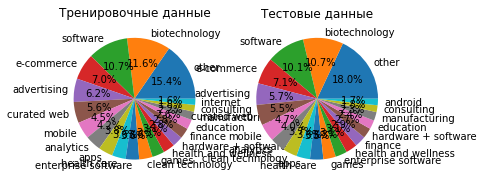

In [71]:
categ('category_list_other', 20)

`Вывод:` *Распределение самых больших по доле стартапов в них категорий в обеих таблицах похожа:*
- самая большая доля у категории other - 15-18%
- меньше - biotechnology - 11-12%
- меньше - software - 10-11%
- затем e-commerce - 7% и т.д.

### funding_total_usd

In [72]:
print('Статистика тренировочных данных')
print(train['funding_total_usd'].describe())
print()
print('Статистика тестовых данных')
print(test['funding_total_usd'].describe())

Статистика тренировочных данных
count    5.163100e+04
mean     1.500166e+07
std      1.698041e+08
min      0.000000e+00
25%      5.000000e+04
50%      1.000000e+06
75%      7.000000e+06
max      3.007950e+10
Name: funding_total_usd, dtype: float64

Статистика тестовых данных
count    1.312100e+04
mean     1.329721e+07
std      8.289857e+07
min      0.000000e+00
25%      4.000000e+04
50%      9.500000e+05
75%      6.500100e+06
max      4.715000e+09
Name: funding_total_usd, dtype: float64


In [73]:
b=50

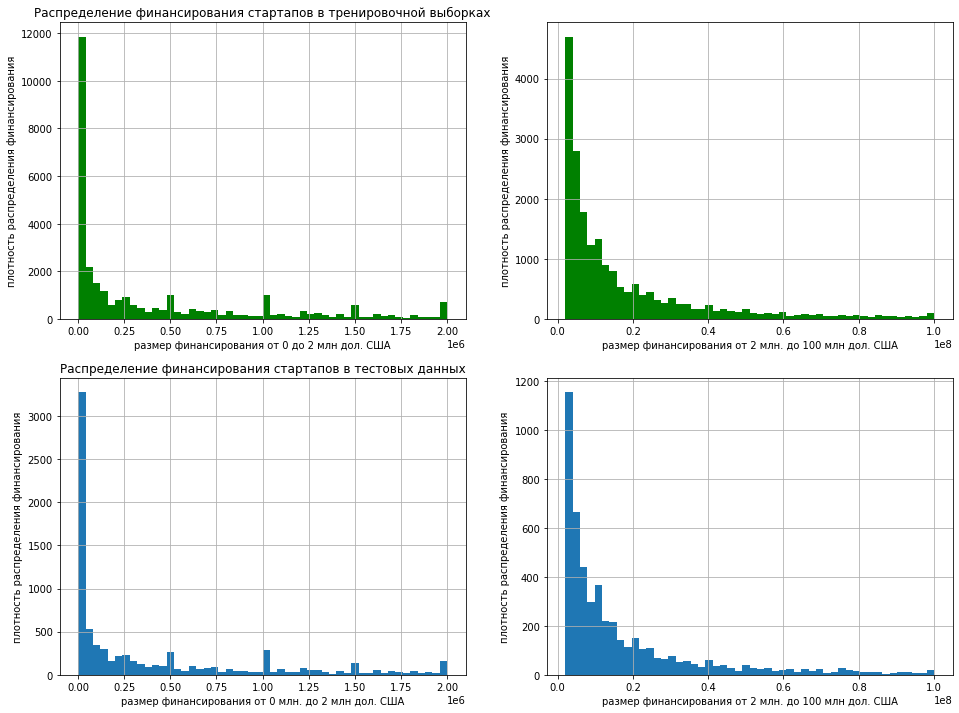

In [74]:
plt.figure(figsize=(16, 12))

plt.subplot(2,2,1)
train['funding_total_usd'].hist(bins=b, range=(0, 2000000), color = 'green')
plt.ylabel('плотность распределения финансирования')
plt.xlabel('размер финансирования от 0 до 2 млн дол. США')
plt.title('Распределение финансирования стартапов в тренировочной выборках')

    # !!! Текущая ячейка - 2
plt.subplot(2, 2, 2)
train['funding_total_usd'].hist(bins=b, range=(2000000, 100000000), color = 'green')
plt.xlabel('размер финансирования от 2 млн. до 100 млн дол. США')
plt.ylabel('плотность распределения финансирования')

plt.subplot(2, 2, 3)
test['funding_total_usd'].hist(bins=b, range=(0, 2000000))
plt.xlabel('размер финансирования от 0 млн. до 2 млн дол. США')
plt.title('Распределение финансирования стартапов в тестовых данных')
plt.ylabel('плотность распределения финансирования')

plt.subplot(2, 2, 4)
test['funding_total_usd'].hist(bins=b, range=(2000000, 100000000))
plt.xlabel('размер финансирования от 2 млн. до 100 млн дол. США')
plt.ylabel('плотность распределения финансирования')

    # Покажем окно с нарисованным графиком
plt.show()

Основная часть стартапов в обеих таблицах либо имеет финансирование от 0 до 200 тыс. дол. Распределения финансирования обеих выборок похожи.

Рассмотрим ящики с усами.

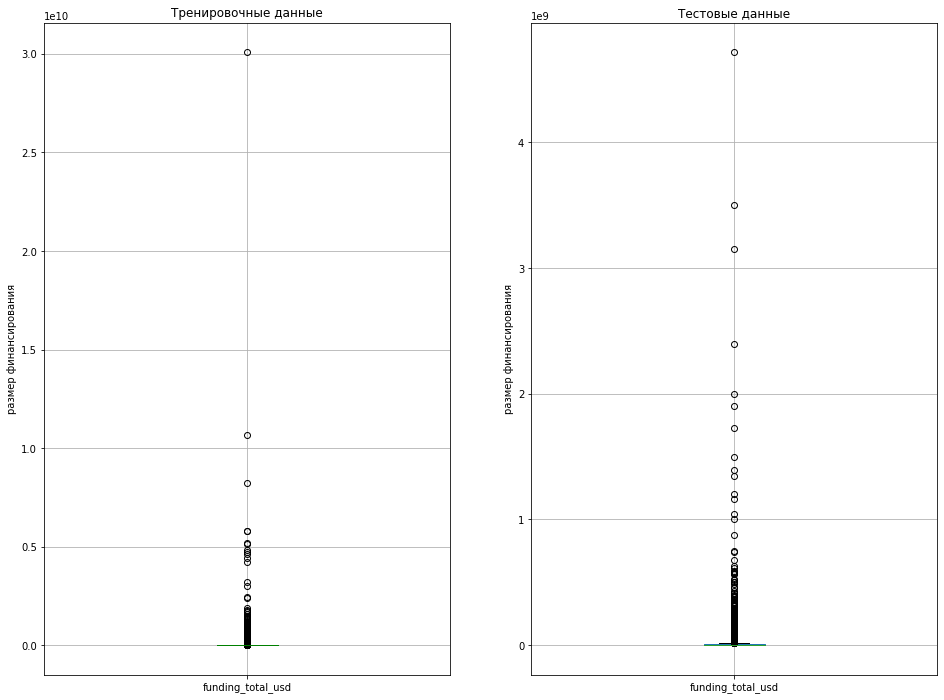

In [75]:
plt.figure(figsize=(16, 12))

plt.subplot(1,2,1)
train.boxplot('funding_total_usd', color = 'green')
plt.ylabel('размер финансирования')
plt.title('Тренировочные данные')

plt.subplot(1,2,2)
test.boxplot('funding_total_usd')
plt.ylabel('размер финансирования')
plt.title('Тестовые данные')
    
plt.show()

Видим выбросы слишком далекие от основной массы данных.

`Вывод:` *Основная часть стартапов финансируется в размере от 0 до 200 ты с. дол США. В данных есть выбросы.Тренировочная и тестовые выборки распределены одинаково. Можно разделить на подгруппы: финансирование 0-200 тыс., 200 тыс. и более.*

### country_code

In [76]:
print('Стран в тренировочной таблице - ', train['country_code'].value_counts().count())
print('Стран в тестовой таблице - ', test['country_code'].value_counts().count())

Стран в тренировочной таблице -  134
Стран в тестовой таблице -  96


Тренировочные данные
USA    29701
GBR     2925
CAN     1540
IND     1276
CHN     1240
FRA      916
DEU      834
ISR      767
ESP      607
NLD      380
AUS      379
Name: country_code, dtype: int64

Тестовые данные
USA    7425
GBR     724
CAN     369
IND     307
CHN     301
DEU     237
FRA     213
ISR     190
ESP     134
AUS     120
NLD     112
Name: country_code, dtype: int64


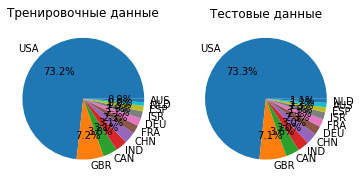

In [77]:
categ('country_code', 11)

Распределение между странами в тестовой и тренировочной таблицах также похоже, из самых объемных 11 стран: 73% - США, 7% - GBR, 4% - CAN и т.д.

Посмотрим, что в конце рейтинга стран.

In [78]:
train['country_code'].value_counts().tail(30)

ZWE    2
GIB    2
BAH    2
MKD    2
CMR    2
HND    2
LKA    2
MOZ    2
UZB    1
MNE    1
GGY    1
SOM    1
MAF    1
SYC    1
OMN    1
BLM    1
GRD    1
ZMB    1
NIC    1
PSE    1
PRY    1
KAZ    1
KNA    1
TGO    1
QAT    1
SEN    1
DZA    1
IRN    1
JEY    1
BRN    1
Name: country_code, dtype: int64

In [79]:
test['country_code'].value_counts().tail(30)

SRB    3
BLR    3
GHA    3
CIV    2
MMR    2
UGA    2
TTO    2
TAN    2
MUS    1
GTM    1
HRV    1
LKA    1
PSE    1
SAU    1
BMU    1
LBN    1
MKD    1
DMA    1
BHR    1
BWA    1
CMR    1
JAM    1
ZWE    1
NIC    1
PAN    1
AZE    1
BRB    1
ECU    1
VEN    1
ZMB    1
Name: country_code, dtype: int64

`Вывод по странам:`*Список стран, где по 1-3 стартапа достаточно большой. При этом 70% всех стартапов открыто в США. Это говорит о дисбалансе в данном признаке. Распределения в тестовой и тренировочной таблицах похожи, значит стратификация выполнена.*

*США является мажорным классом, для него нужно будет сделать Undersampling.*

### funding_rounds

Тренировочные данные
1     32644
2      9783
3      4447
4      2187
5      1166
6       616
7       341
8       175
9       109
10       63
11       46
12       22
13        9
16        6
14        5
15        5
17        3
18        3
19        1
Name: funding_rounds, dtype: int64

Тестовые данные
1     8449
2     2423
3     1110
4      533
5      288
6      152
7       75
8       39
9       17
10      16
12       6
13       6
11       5
14       1
15       1
Name: funding_rounds, dtype: int64


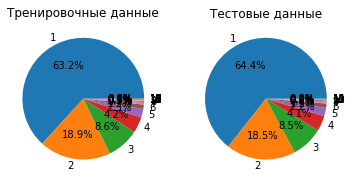

In [80]:
categ('funding_rounds', 19)

`Вывод:` *По количеству раундов в обеих выборках данные распределены одинаково: 63-64% процента финансировались 1 раунд, 19% два раунда, 9% - три раунда и т.д. Отличие между таблицами в количестве раундов: в тестовых данных их на 4 меньше. Имеет смысл разделить на подгруппы: 1 раунд, не один раунд.*

### first_funding_at

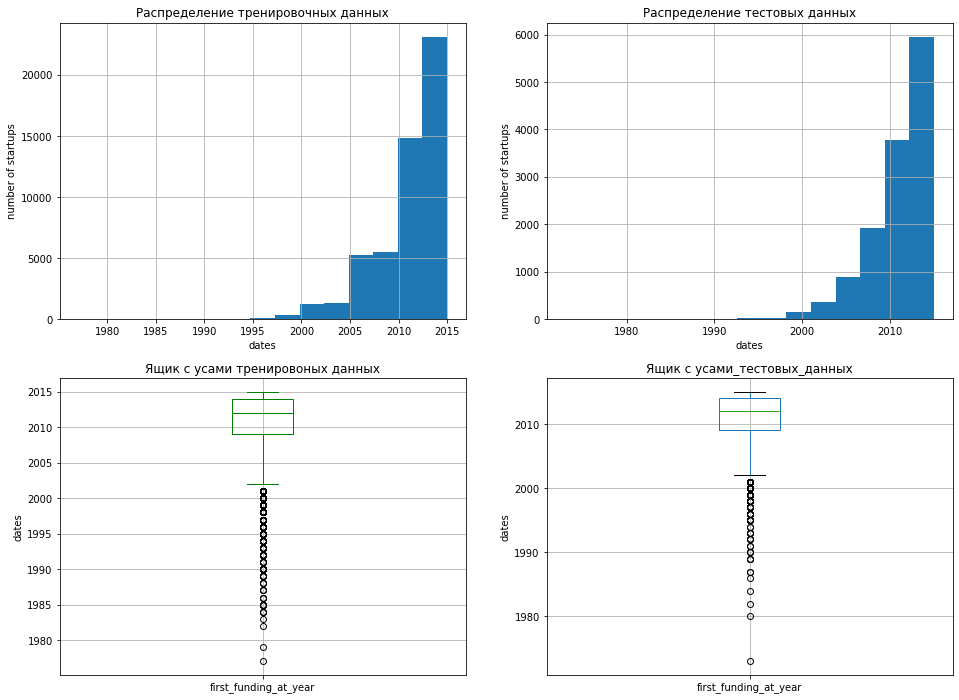

Статистика тренировочных данных
count    51631.000000
mean      2011.065561
std          3.601647
min       1977.000000
25%       2009.000000
50%       2012.000000
75%       2014.000000
max       2015.000000
Name: first_funding_at_year, dtype: float64

Статистика тестовых данных
count    13121.000000
mean      2011.094353
std          3.644357
min       1973.000000
25%       2009.000000
50%       2012.000000
75%       2014.000000
max       2015.000000
Name: first_funding_at_year, dtype: float64


In [81]:
numbers('first_funding_at_year', 'dates', 'number of startups')

`Вывод:` *Распределения полностью по датам и только по годам проведения раундов похожи. Значит, можно принять к исследованию только годы проведения раундов, так проще проводить исследование. В тренировочных данных основная часть, примерно 23 тыс. раундов проходили в 2012-2015 гг. В остальные годы, чем раньше, тем меньше, раудов проходило намного меньше. Медиана приходится на 2012 г. В тестовых данных также пик приходится на те же годы - примерно 5,8 тыс. раундов. Ранее 2002 года видны лишь единичные случаи раундов в обеих таблицах. Можно разделить на подгруппы до 2002 г., 2002-2012 гг, 2012-2015 гг.* 

Также исследуем только год даты последнего раунда.

### last_funding_at_year

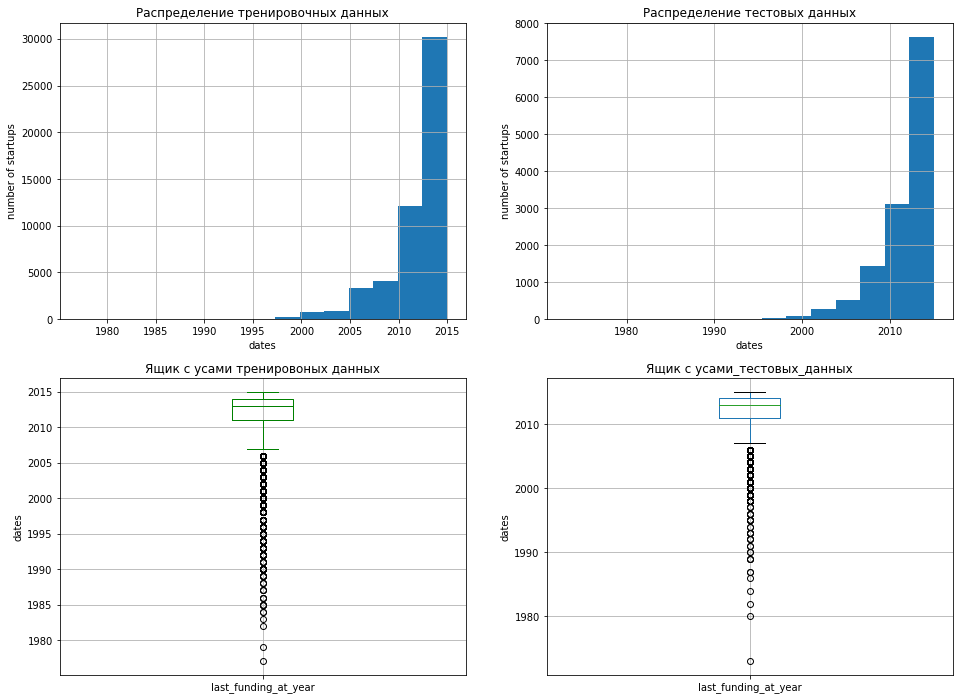

Статистика тренировочных данных
count    51631.000000
mean      2012.017063
std          3.319765
min       1977.000000
25%       2011.000000
50%       2013.000000
75%       2014.000000
max       2015.000000
Name: last_funding_at_year, dtype: float64

Статистика тестовых данных
count    13121.000000
mean      2011.981404
std          3.391339
min       1973.000000
25%       2011.000000
50%       2013.000000
75%       2014.000000
max       2015.000000
Name: last_funding_at_year, dtype: float64


In [82]:
numbers('last_funding_at_year', 'dates', 'number of startups')

`Вывод:` *В обеих выборках основная часть последних раундов приходится на те же годы - 2012-2015 гг. Это соответствует факту, что у большинства стартапов был один раунд финансирования - первый и он же последний. Медиана - 2013 г. Проблему вижу в том, что и в первом и в последнем раундах модель быдет учиться на годах минимум 1977 г, а в тестовой выборке самый ранний год 1973 г. До 2002 г. встречаются единичные случаи последних раундов. Стратификация соблюдена.*

### lifetime

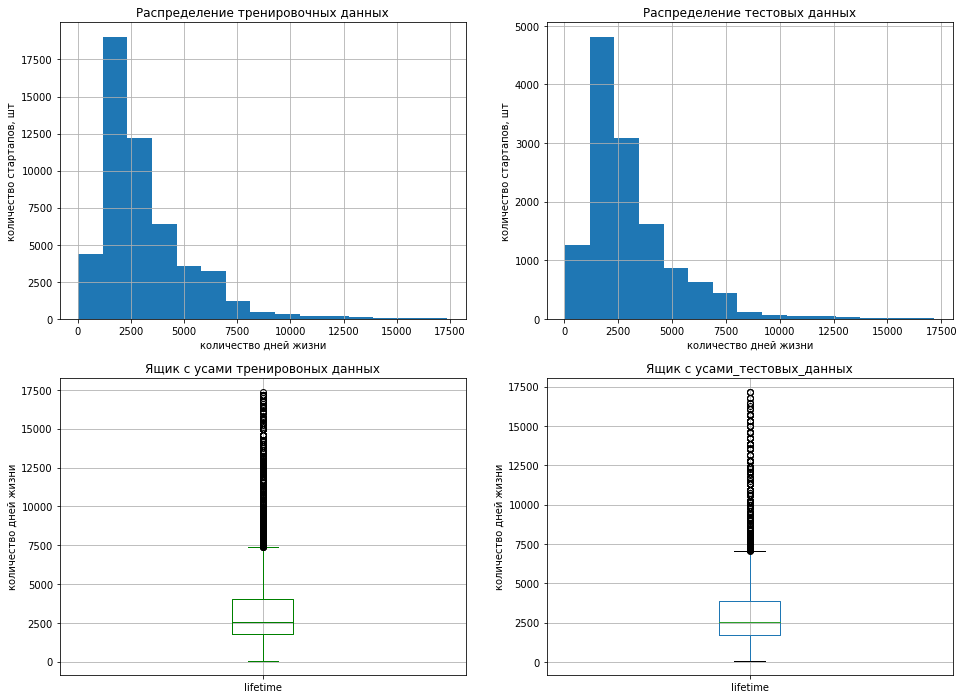

Статистика тренировочных данных
count    51631.000000
mean      3158.142298
std       2150.839414
min         19.000000
25%       1762.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64

Статистика тестовых данных
count    13121.000000
mean      3097.710007
std       2128.441123
min         52.000000
25%       1726.000000
50%       2526.000000
75%       3866.000000
max      17167.000000
Name: lifetime, dtype: float64


In [83]:
numbers('lifetime', 'количество дней жизни','количество стартапов, шт')

Рсапределение обоих наборов данных похожи, значит, стратификация выполнена. Есть большое количество выбросов. Жизнь среднего стартапа длится 2500 дней, это около 7 лет. Есть стартапы, дожившие до 47 лет.

### status

Тренировочные данные
operating    47024
closed        4607
Name: status, dtype: int64

Тестовые данные
operating    6633
closed       6488
Name: status, dtype: int64


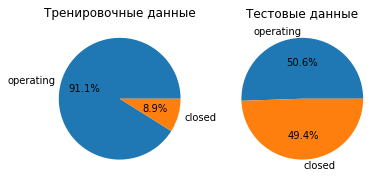

In [84]:
categ('status', 3)

В целевом признаке закрытые/незакрыте стартапы распределены неодинаково: в тренировочных данных 91 процент незакрытых стртапов, в тестовой - 51%. Есть вероятность, что модель будет чаще классифицировать стартапы как работающие.

**Вывод:** *Данные с выбросами, с дисбалансом в признаке Страна, количество раундов, целевой переменной Статус с огромным списком классов в Стране, категории.*

## Корреляционный анализ



In [85]:
train.columns

Index(['name', 'funding_total_usd', 'status', 'country_code', 'funding_rounds',
       'first_funding_at_year', 'last_funding_at_year', 'lifetime',
       'category_list_other'],
      dtype='object')

Рассмотрим матрицу корреляции по подгруппам. Можно разделить данные на подгруппы по трем признакам:

1. funding_total_usd: 0-200 тыс. и 200 и более
2. country_code: США и не США,
3. funding_rounds: 1 раунд, более 1 раунда
4. first_funding_at: 2012-2015 гг., 2002-2011 г, ранее 2002 г.
5. status: operating, closed.





Столбец name является идентификатором, поэтому также не учавствует в исследовании. Рассмотрим новые таблицы без этих столбцов.

In [86]:


train_cor = train.drop(columns = 'name', axis = 1)
print(train.columns)
               
test_cor = test.drop(columns = 'name', axis = 1)  
test.columns             

Index(['name', 'funding_total_usd', 'status', 'country_code', 'funding_rounds',
       'first_funding_at_year', 'last_funding_at_year', 'lifetime',
       'category_list_other'],
      dtype='object')


Index(['name', 'funding_total_usd', 'country_code', 'funding_rounds',
       'lifetime', 'first_funding_at_year', 'last_funding_at_year',
       'category_list_other', 'status'],
      dtype='object')

### status: operating, closed

In [87]:
def matriza (condition1, condition2):
    plt.figure(figsize=(16, 12))
    train_1 = train_cor.query(condition1)
    test_1 = test_cor.query(condition1)
    train_2 = train_cor.query(condition2)
    test_2 = test_cor.query(condition2)
    interv_col = ['funding_total_usd', 'funding_rounds', 'first_funding_at_year', 'last_funding_at_year', 'lifetime']
    
    plt.subplot(2,2,1)
    corr_matrix = train_1.phik_matrix(interval_cols= interv_col)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Тренировочные данные, условие 1')

    plt.subplot(2, 2, 2)
    corr_matrix = train_2.phik_matrix(interval_cols=interv_col)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Тренировочные данные, условие 2')
    
    plt.subplot(2,2,3)
    corr_matrix = test_1.phik_matrix(interval_cols= interv_col)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Тестовые данные, условие 1')
    
    plt.subplot(2,2,4)
    corr_matrix = test_2.phik_matrix(interval_cols=interv_col)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Тестовые данные, условие 2')
    
    plt.show()
    return

   

    

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable status for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable status for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable status for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable status for analysis 1. Dropping this column
  warnings.warn(


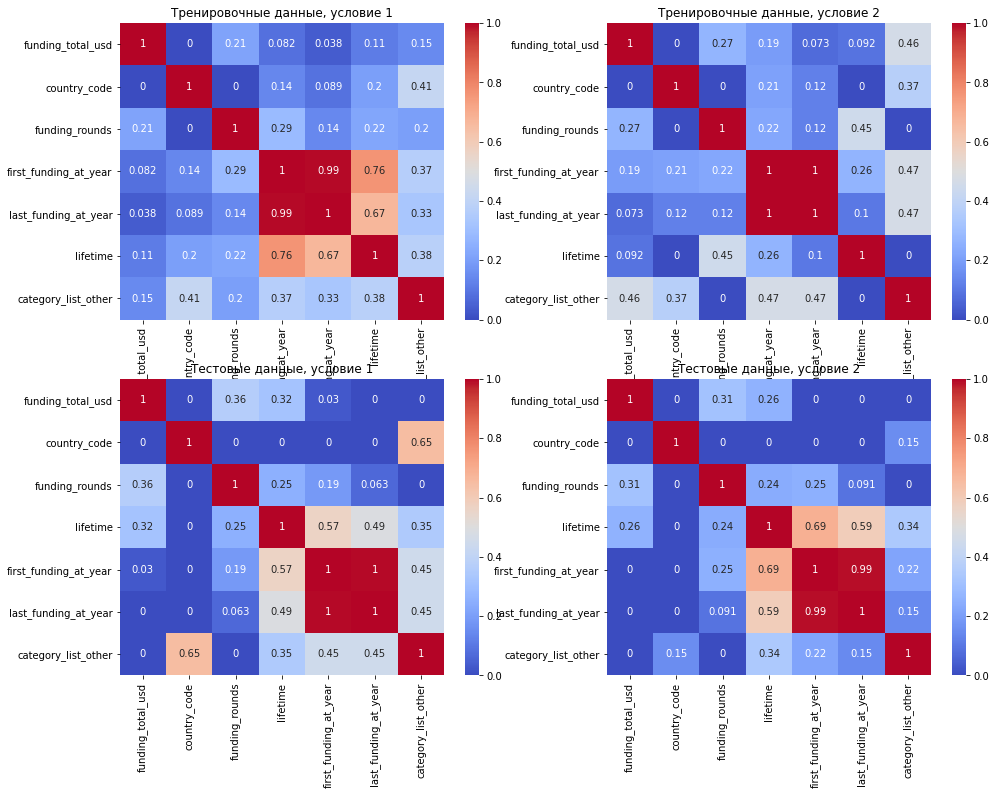

In [88]:
matriza('status == "operating"', 'status == "closed"')

В открытых стартапах прослеживается взаимосвязь времени жизни и годов первого раунда в тренировоных данных, связь категории и страны в тестовой.

В закрытых стартапах только в тествых данных слабая связь раундов и времени жизни.

### funding_rounds

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable funding_rounds for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable funding_rounds for analysis 1. Dropping this column
  warnings.warn(


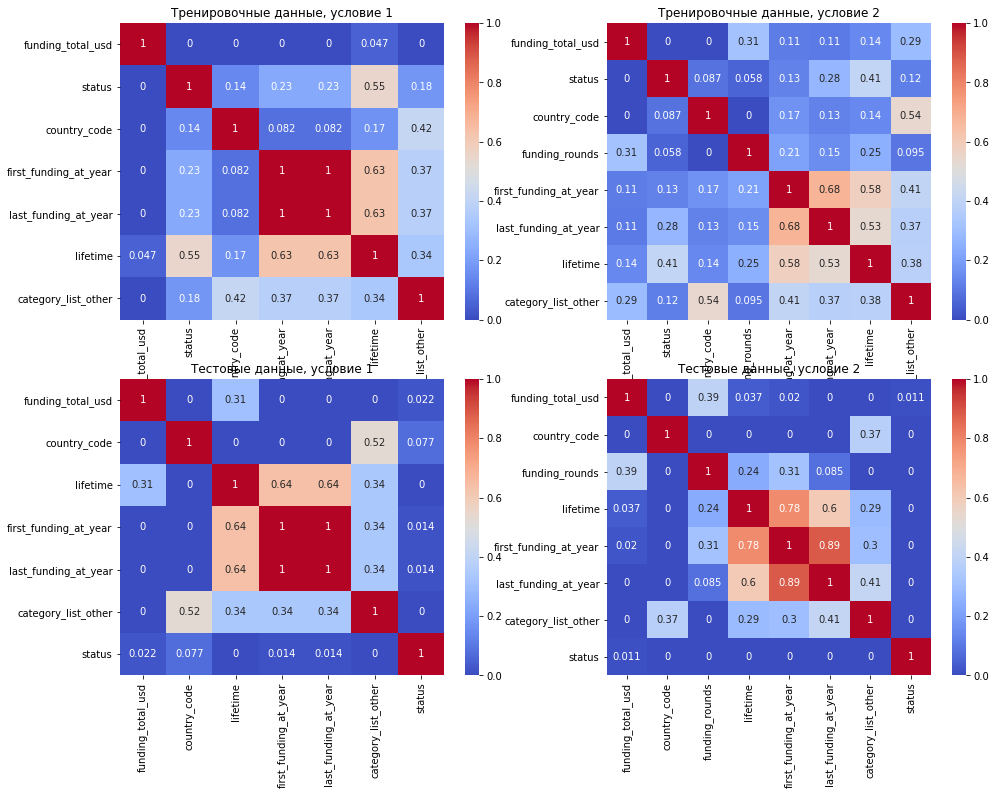

In [89]:
matriza('funding_rounds == 1', 'funding_rounds > 1')

Там где один раунд время жизни и раунды.

Там, где не один раунд связи также время жизни и годы раундов.




### funding_total_usd

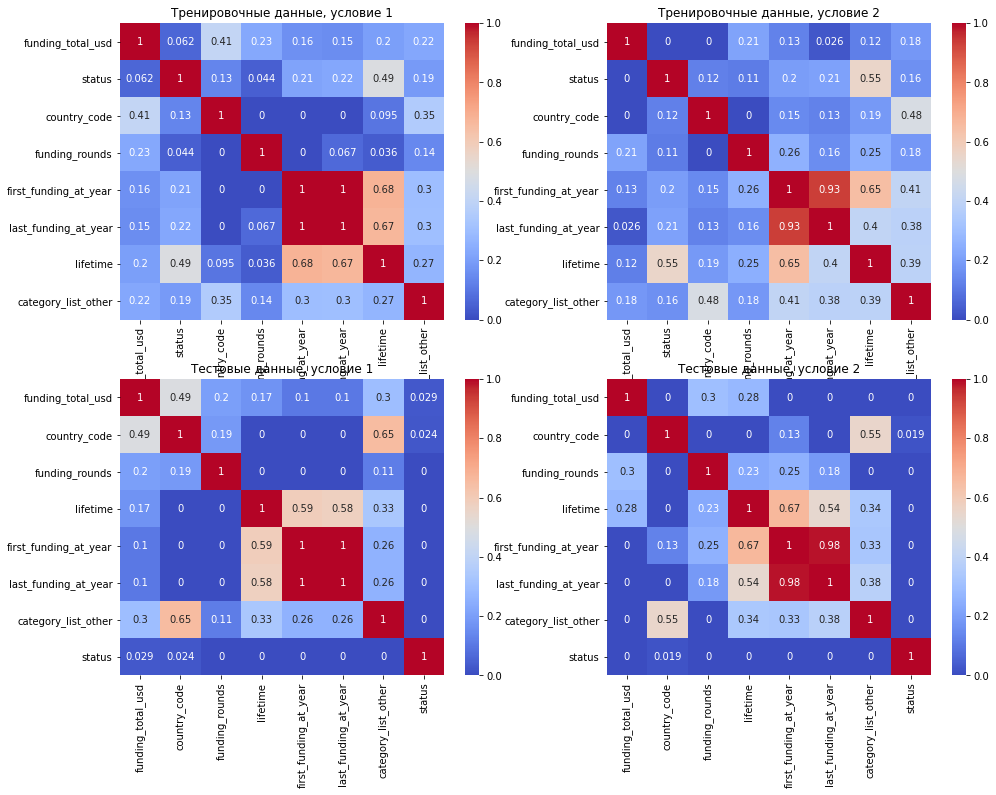

In [90]:
matriza('funding_total_usd <200000', 'funding_total_usd >= 200000')

Во всех данных независимо от уровня финансирования связь категории и страны. В тестовых данных при малом или отсутствующем финансировании также есть связь категории и количества раундов финансирования.

### country_code

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable country_code for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable country_code for analysis 1. Dropping this column
  warnings.warn(


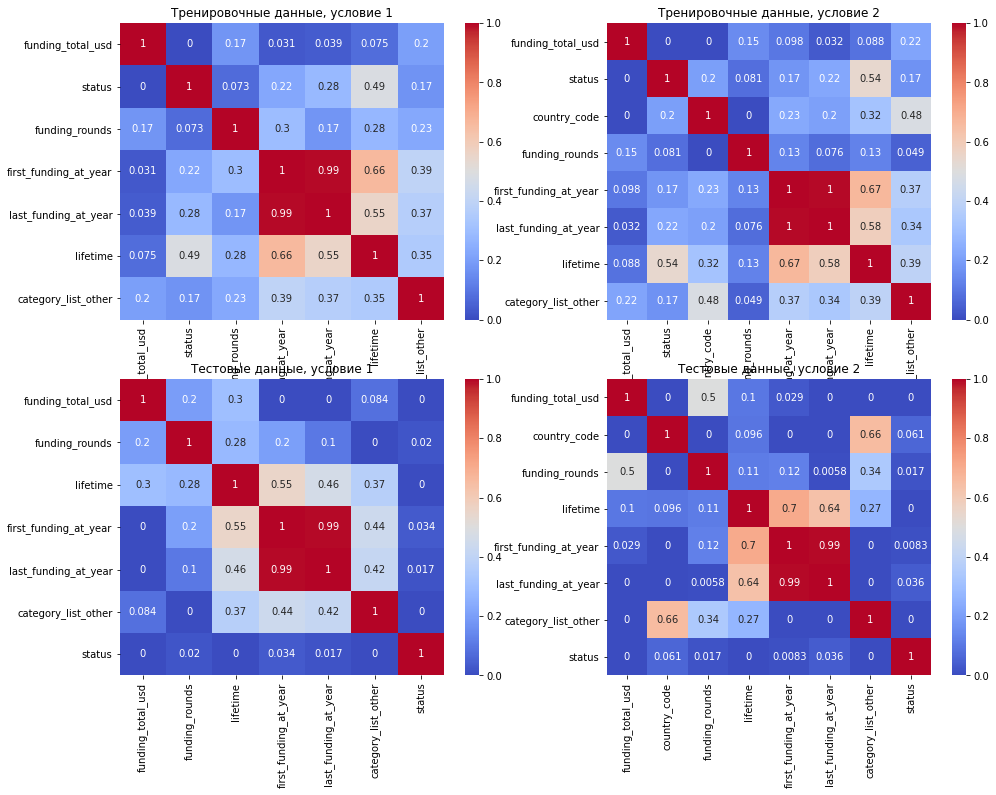

In [91]:
matriza('country_code =="USA"', 'country_code != "USA"')

В данных США нет взаимосвязей. 

В данных не из США есть небольшая связь категории со страной и количеством раундов.

### first_funding_at

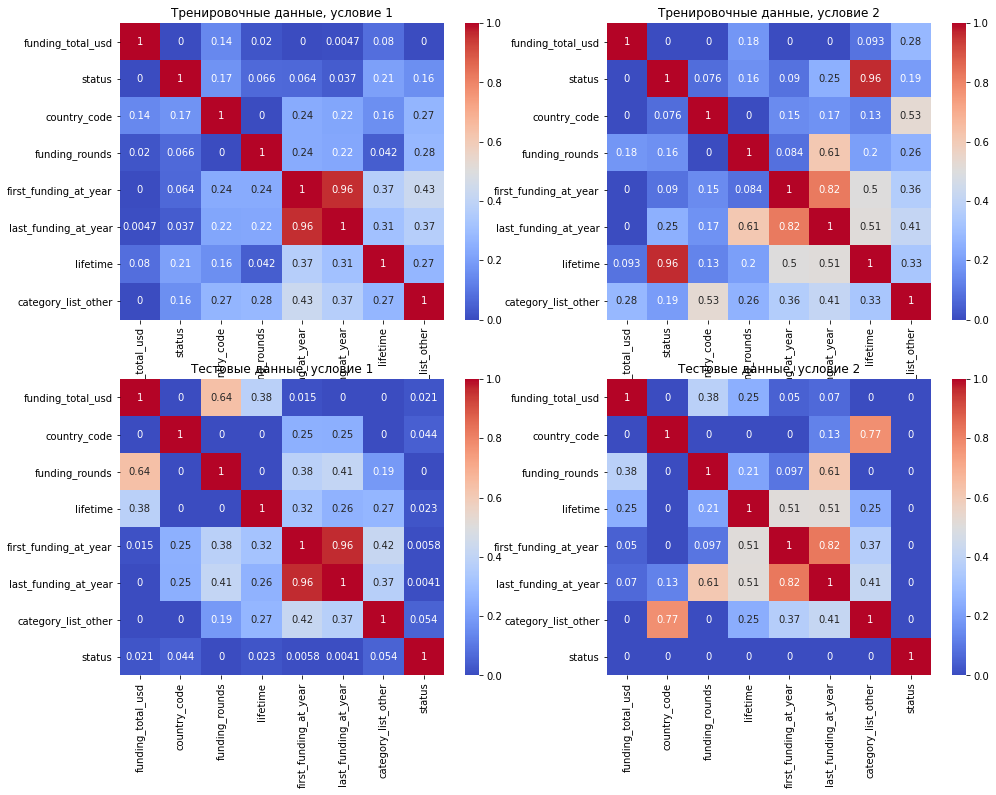

In [92]:
matriza('2012 < first_funding_at_year <= 2015', '2002 < first_funding_at_year <= 2011')

Везде слабые связи между страной и категорией, сроком жизни и годами раундов.

`Вывод:` *с учетом отобранных признаков мультиколлинеарностm наблюдается только между первым и последним раундом нет, зависимости целевого признака Статус от других признаков нет. Утечки данных нет.*

### Построим диаграммы рассеяния scatterplot для признака Статус и всех количественных признаков с учётом значения категориальных признаков

In [93]:
train.columns

Index(['name', 'funding_total_usd', 'status', 'country_code', 'funding_rounds',
       'first_funding_at_year', 'last_funding_at_year', 'lifetime',
       'category_list_other'],
      dtype='object')

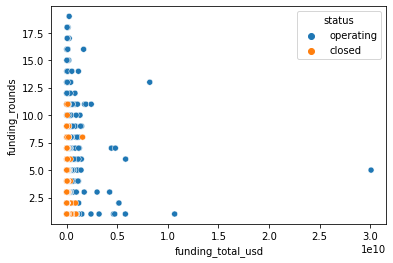

In [94]:
sns.scatterplot(data=train_cor, x="funding_total_usd", y="funding_rounds",  hue="status");

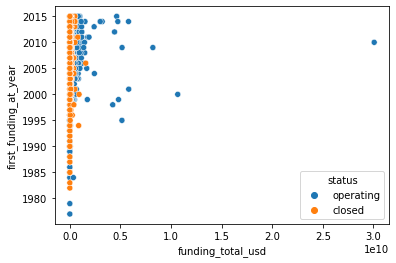

In [95]:
sns.scatterplot(data=train_cor, x="funding_total_usd", y="first_funding_at_year",  hue="status");

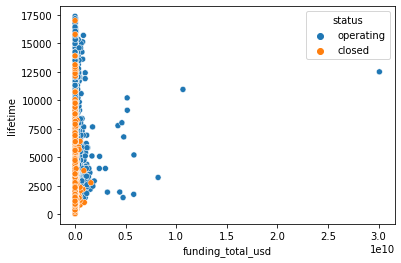

In [96]:
sns.scatterplot(data=train_cor, x="funding_total_usd", y="lifetime",  hue="status");

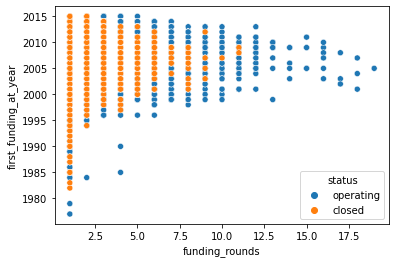

In [97]:
sns.scatterplot(data=train_cor, x="funding_rounds", y="first_funding_at_year",  hue="status");

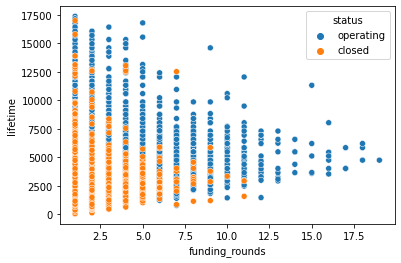

In [98]:
sns.scatterplot(data=train_cor, x="funding_rounds", y="lifetime",  hue="status");

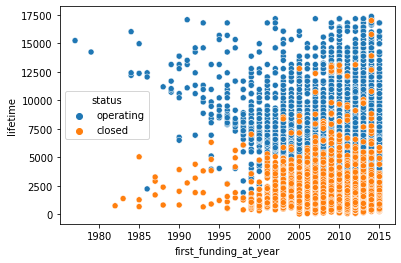

In [99]:
sns.scatterplot(data=train_cor, x="first_funding_at_year", y="lifetime",  hue="status");

Диаграммы рассеяния показали, что закрываются стартапы после 11 раунда. И что дополнительных синтетических признаков не найти.

## Выбор и обучение моделей

### Поготовка целевого признака

In [100]:
print(train.info())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51631 entries, 0 to 51630
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   51631 non-null  object 
 1   funding_total_usd      51631 non-null  float64
 2   status                 51631 non-null  object 
 3   country_code           47013 non-null  object 
 4   funding_rounds         51631 non-null  int64  
 5   first_funding_at_year  51631 non-null  int64  
 6   last_funding_at_year   51631 non-null  int64  
 7   lifetime               51631 non-null  int64  
 8   category_list_other    51631 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 3.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13121 entries, 0 to 13120
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   13121 non-nul

7 признаков: категориальных и числовых.

Кодируем целевой признак.

In [101]:
train['status'].unique()

array(['operating', 'closed'], dtype=object)

In [102]:
le = LabelEncoder()
le.fit(["operating", "closed"])
LabelEncoder()

target_train = le.transform(train['status'])

#display(pd.DataFrame(zip(train['status'][:5], target[:5]), columns = ['status','метка']))
display(pd.DataFrame(zip(train['status'], target_train), columns = ['status','метка']))

,status,метка
0,operating,1
1,operating,1
2,operating,1
3,operating,1
4,operating,1
...,...,...
51626,closed,0
51627,closed,0
51628,closed,0
51629,closed,0


In [103]:
target_test = le.transform(test['status'])

#display(pd.DataFrame(zip(train['status'][:5], target[:5]), columns = ['status','метка']))
display(pd.DataFrame(zip(test['status'], target_test), columns = ['status','метка']))

,status,метка
0,closed,0
1,operating,1
2,closed,0
3,closed,0
4,operating,1
...,...,...
13116,operating,1
13117,operating,1
13118,closed,0
13119,operating,1


### Паплайн. Подготовка признаков

In [104]:
X_train_ = train.drop(columns = ['name', 'status' ], axis=1)
X_test = test.drop(columns = ['name', 'status'], axis=1)
#X_train_ = train.drop(columns = 'status', axis=1)
#X_test = test.drop(columns = 'status', axis=1)

y_train_ = target_train
y_test = target_test

In [105]:
print(X_train_.info())
print(X_test.info())
print(train['status'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51631 entries, 0 to 51630
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funding_total_usd      51631 non-null  float64
 1   country_code           47013 non-null  object 
 2   funding_rounds         51631 non-null  int64  
 3   first_funding_at_year  51631 non-null  int64  
 4   last_funding_at_year   51631 non-null  int64  
 5   lifetime               51631 non-null  int64  
 6   category_list_other    51631 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13121 entries, 0 to 13120
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funding_total_usd      13121 non-null  float64
 1   country_code           11739 non-null  object 
 2   funding_rounds         13121 non-nul

In [106]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_,
    y_train_,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = train['status'])

print(X_train.info())
print(X_val.info())
print(len(y_train))
print(len(y_val))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38723 entries, 34334 to 46930
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funding_total_usd      38723 non-null  float64
 1   country_code           35273 non-null  object 
 2   funding_rounds         38723 non-null  int64  
 3   first_funding_at_year  38723 non-null  int64  
 4   last_funding_at_year   38723 non-null  int64  
 5   lifetime               38723 non-null  int64  
 6   category_list_other    38723 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 2.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12908 entries, 49176 to 25995
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funding_total_usd      12908 non-null  float64
 1   country_code           11740 non-null  object 
 2   funding_rounds         12908

### Паплайн

In [107]:
num_columns = X_train.select_dtypes(include = 'number').columns.tolist()
num_columns

['funding_total_usd',
 'funding_rounds',
 'first_funding_at_year',
 'last_funding_at_year',
 'lifetime']

In [108]:
ord_columns = ['country_code', 'category_list_other'] #так как категориЙ достаточно много, поэтому  применим OrdinalEncoder

In [109]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
   
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline([('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])



param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     #словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
     },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['country_code',
                                               

Паплайн выбрал модель дерево решений с глубиной 4, с максимальным количеством узлов 2

In [110]:

print('Метрика после кросвалидации на валидационной выборке',round(cross_val_score(randomized_search.best_estimator_, X_val, y_val, cv=5, scoring='f1').mean(),2))


Метрика после кросвалидации на валидационной выборке 0.98


Метрика на тренировочных и валидационных данных очень хорошая, видимо подходящая модель найдена. Проверим на тестовых.

In [111]:
print('Метрика F1 на тестовых данных -', round(f1_score(y_test, randomized_search.predict(X_test), pos_label=1),2))

Метрика F1 на тестовых данных - 0.65


`Вывод:` *На тестовых данных метрика 0.65, что гораздо хуже, чем на ренировочных, 098. Модель переобучилась возможно по причине дисбаланса входных признаков категории страны. Для устранения дисбаланса может помочь андэрсэмплинг*

### Undersampling

In [112]:
sampler = RandomUnderSampler(random_state=42)
X_resample, y_resample = sampler.fit_resample(X_train, y_train)
print(X_resample.shape)
y_resample.shape

(6910, 7)


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


(6910,)

In [113]:
X_resample['country_code']

50364    USA
49709    NaN
51120    USA
49332    NaN
47147    USA
        ... 
4290     USA
38715    USA
27143    USA
30302    USA
36814    USA
Name: country_code, Length: 6910, dtype: object

Тренировочные данные
USA    3733
GBR     372
CAN     205
IND     129
CHN     121
RUS     118
FRA     106
DEU     101
ISR     101
ESP      78
SWE      74
Name: country_code, dtype: int64

Тестовые данные
USA    7425
GBR     724
CAN     369
IND     307
CHN     301
DEU     237
FRA     213
ISR     190
ESP     134
AUS     120
NLD     112
Name: country_code, dtype: int64


Text(0.5, 1.0, 'Тестовые данные')

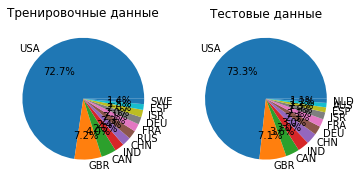

In [114]:
    v1 = X_resample['country_code'].value_counts().head(11)
    v2 = test['country_code'].value_counts().head(11)
    
    print('Тренировочные данные')
    print(v1)
    print()
    print('Тестовые данные')
    print(v2)

    lb1 = v1.index
    lb2 = v2.index

    fig, ax = plt.subplots(1,2)

    ax[0].pie(v1, labels=lb1, autopct='%1.1f%%')
    ax[0].set_title('Тренировочные данные')
    ax[1].pie(v2, labels=lb2, autopct='%1.1f%%')
    ax[1].set_title('Тестовые данные')

Ничего не изменилось.

Сделаем сэмплирование вручную.

In [115]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51631 entries, 0 to 51630
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   51631 non-null  object 
 1   funding_total_usd      51631 non-null  float64
 2   status                 51631 non-null  object 
 3   country_code           47013 non-null  object 
 4   funding_rounds         51631 non-null  int64  
 5   first_funding_at_year  51631 non-null  int64  
 6   last_funding_at_year   51631 non-null  int64  
 7   lifetime               51631 non-null  int64  
 8   category_list_other    51631 non-null  object 
dtypes: float64(1), int64(4), object(4)
memory usage: 3.5+ MB


In [116]:

df = train.drop(columns='name')

# формируем тренировочную и тестовую выборки
train_df, test_df = train_test_split(df, random_state=RANDOM_STATE, stratify=df["status"])

# проверка баланса данных в исходном датасете
print(f'Тренировочные данные до сэмплирования:\n{train_df.country_code.value_counts()}')

# вычисляем размера дисбаланса: узнаём, насколько данных мажорного класса больше
delta = train_df.country_code.value_counts()['USA'] - train_df.country_code.value_counts()['GBR']

# отбираем случайные объекты мажорного класса для удаления
deleted_index = train_df.query("country_code=='USA'").sample(delta).index

# удаляем наблюдения мажорного класса и сохраняем итоговый датасет
df_sampled = train_df[~train_df.index.isin(deleted_index)]

# проверка баланса данных в сэмплированном датасете
print(f'\nТренировочные данные после сэмплирования:\n{df_sampled.country_code.value_counts()}') 

Тренировочные данные до сэмплирования:
USA    22320
GBR     2207
CAN     1170
IND      969
CHN      917
       ...  
JEY        1
BLZ        1
GRD        1
UZB        1
MAR        1
Name: country_code, Length: 126, dtype: int64

Тренировочные данные после сэмплирования:
USA    2207
GBR    2207
CAN    1170
IND     969
CHN     917
       ... 
GGY       1
MOZ       1
GRD       1
MAR       1
KAZ       1
Name: country_code, Length: 126, dtype: int64


In [117]:
print('Тренировочные данные до сэмплирования:')
print()
print(train_df.info())
print('Тренировочные данные после сэмплирования:')
print()    
print(df_sampled.info())
print()
print('Размер валидационной выборки для сэмплирования',test_df.shape)

Тренировочные данные до сэмплирования:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38723 entries, 34334 to 46930
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   funding_total_usd      38723 non-null  float64
 1   status                 38723 non-null  object 
 2   country_code           35273 non-null  object 
 3   funding_rounds         38723 non-null  int64  
 4   first_funding_at_year  38723 non-null  int64  
 5   last_funding_at_year   38723 non-null  int64  
 6   lifetime               38723 non-null  int64  
 7   category_list_other    38723 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 2.7+ MB
None
Тренировочные данные после сэмплирования:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18610 entries, 11135 to 468
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0  

In [118]:
X_train_sampled = df_sampled.drop(columns = ['status'], axis=1) #входные признаки тренировочной выборки

X_val_sampled = test_df.drop(columns = ['status'], axis=1) #входные признаки валидационной выборки

#le = LabelEncoder()
#le.fit(["operating", "closed"])
#LabelEncoder()

target_train_sampled = le.transform(df_sampled['status'])

#display(pd.DataFrame(zip(train['status'][:5], target[:5]), columns = ['status','метка']))
print('Таблица закодированного признака в сравнении с незакодированным')
display(pd.DataFrame(zip(df_sampled['status'], target_train_sampled), columns = ['status','метка']))

y_train_sampled = target_train_sampled

y_val_sampled = le.transform(test_df['status'])

print('Размер закодированный целевой признак', y_train_sampled.shape )

print('Размер закодированный целевой признак валидационной выборки', y_val_sampled.shape)

Таблица закодированного признака в сравнении с незакодированным


,status,метка
0,operating,1
1,operating,1
2,operating,1
3,operating,1
4,operating,1
...,...,...
18605,closed,0
18606,closed,0
18607,operating,1
18608,operating,1


Размер закодированный целевой признак (18610,)
Размер закодированный целевой признак валидационной выборки (12908,)


In [119]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
   
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline([('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])



param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     #словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
     },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search_sampled = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_sampled.fit(X_train_sampled, y_train_sampled)

print('Лучшая модель и её параметры:\n\n', randomized_search_sampled.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_sampled.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['country_code',
                                               

In [120]:
print('Метрика после кросcвалидации на валидационной выборке')
print(round(cross_val_score(randomized_search_sampled.best_estimator_, X_val_sampled, y_val_sampled, cv=5, scoring='f1')
            .mean(),2))

Метрика после кросcвалидации на валидационной выборке
0.98


In [121]:
print('Метрика F1 на тестовых данных -', round(f1_score(y_test, randomized_search_sampled.predict(X_test), pos_label=1),2))

Метрика F1 на тестовых данных - 0.65


Метрика после андерсэмплинга не изменилась. Видимо, это произошло потому, что дибланс в тренировочной и тестовой выборках одинаков, стратификация выполонена, поэтому изменение баланса в тренировочной выборке на тестовую не повлияли.

Обратимся к полинамизации признаков.

### Полиномизация признаков

In [122]:
X_val

,funding_total_usd,country_code,funding_rounds,first_funding_at_year,last_funding_at_year,lifetime,category_list_other
49176,2.500000e+04,POL,1,2013,2013,461,legal
38720,0.000000e+00,USA,1,2015,2015,1086,food processing
9415,2.323500e+07,USA,5,2012,2015,2557,electrical distribution
32966,2.087959e+07,USA,5,2010,2015,4383,advertising
47733,4.351489e+06,GBR,1,2014,2014,865,market research
...,...,...,...,...,...,...,...
14515,1.300000e+07,USA,1,2014,2014,2922,artificial intelligence
25117,4.000000e+05,USA,1,2010,2010,3329,software
48045,3.000000e+07,JPN,1,2015,2015,1190,other
2911,3.340080e+05,NaN,1,2014,2014,1913,energy


In [123]:
X_train_num=X_train[num_columns]
X_val_num=X_val[num_columns]
X_test_num=X_test[num_columns]
poly = PolynomialFeatures(degree=2).fit(X_train_num)

# преобразовываем признаки
X_train_poly = poly.transform(X_train_num)
X_val_poly = poly.transform(X_val_num)
X_test_poly = poly.transform(X_test_num)
print(X_train_poly.shape)
print(X_val_poly.shape)
print(X_test_poly.shape)
# для наглядности оборачиваем результат в датафрейм
X_train_poly = pd.DataFrame(X_train_poly, columns=['feature^0', 'feature^1', 'feature^2', 'feature^3', 'feature^4', 'feature^5', 'feature^6', 'feature^7', 'feature^8', 'feature^9', 'feature^10', 'feature^11', 'feature^12', 'feature^13', 'feature^14', 'feature^15', 'feature^16', 'feature^17', 'feature^18', 'feature^19','feature^20'])
X_val_poly = pd.DataFrame(X_val_poly, columns=['feature^0','feature^1','feature^2','feature^3','feature^4',
                                                 'feature^5','feature^6','feature^7','feature^8','feature^9',
                                                 'feature^10','feature^11','feature^12','feature^13','feature^14',
                                                 'feature^15','feature^16','feature^17','feature^18','feature^19',
                                                 'feature^20'])
X_test_poly = pd.DataFrame(X_test_poly, columns=['feature^0', 
                                                 'feature^1',
                                                 'feature^2',
                                                 'feature^3',
                                                 'feature^4',
                                                 'feature^5',
                                                 'feature^6',
                                                 'feature^7',
                                                 'feature^8',
                                                 'feature^9',
                                                 'feature^10',
                                                 'feature^11',
                                                 'feature^12',
                                                 'feature^13',
                                                 'feature^14',
                                                 'feature^15',
                                                 'feature^16',
                                                 'feature^17',
                                                 'feature^18',
                                                 'feature^19',
                                                 'feature^20'])


(38723, 21)
(12908, 21)
(13121, 21)


In [124]:
num_columns_poly = X_train_poly.select_dtypes(include = 'number').columns.tolist()
num_columns_poly

['feature^0',
 'feature^1',
 'feature^2',
 'feature^3',
 'feature^4',
 'feature^5',
 'feature^6',
 'feature^7',
 'feature^8',
 'feature^9',
 'feature^10',
 'feature^11',
 'feature^12',
 'feature^13',
 'feature^14',
 'feature^15',
 'feature^16',
 'feature^17',
 'feature^18',
 'feature^19',
 'feature^20']

In [125]:
X_train_ord_columns = X_train[ord_columns]
X_val_ord_columns = X_val[ord_columns]
X_test_ord_columns = X_test[ord_columns]
X_test_ord_columns.reset_index(drop=True, inplace=True)
X_val_ord_columns.reset_index(drop=True, inplace=True)
X_train_ord_columns.reset_index(drop=True, inplace=True)

In [126]:
X_train_poly = pd.concat([X_train_ord_columns, X_train_poly], axis=1)
X_val_poly = pd.concat([X_val_ord_columns, X_val_poly], axis=1)
X_test_poly = pd.concat([X_val_ord_columns, X_test_poly], axis=1)

In [127]:
ord_pipe = Pipeline(
   [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
   ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
   ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
  ]
)
   
data_preprocessor_poly = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns_poly)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline([('preprocessor', data_preprocessor_poly),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])



param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
   
    #словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
     },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l2',
            class_weight='balanced'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search_poly = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_poly.fit(X_train_poly, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_poly.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_poly.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['country_code',
                                               

In [128]:
len(y_val)

12908

In [129]:
X_val_poly

,country_code,category_list_other,feature^0,feature^1,feature^2,feature^3,feature^4,feature^5,feature^6,feature^7,...,feature^11,feature^12,feature^13,feature^14,feature^15,feature^16,feature^17,feature^18,feature^19,feature^20
0,POL,legal,1.0,2.500000e+04,1.0,2013.0,2013.0,461.0,6.250000e+08,2.500000e+04,...,1.0,2013.0,2013.0,461.0,4052169.0,4052169.0,927993.0,4052169.0,927993.0,212521.0
1,USA,food processing,1.0,0.000000e+00,1.0,2015.0,2015.0,1086.0,0.000000e+00,0.000000e+00,...,1.0,2015.0,2015.0,1086.0,4060225.0,4060225.0,2188290.0,4060225.0,2188290.0,1179396.0
2,USA,electrical distribution,1.0,2.323500e+07,5.0,2012.0,2015.0,2557.0,5.398652e+14,1.161750e+08,...,25.0,10060.0,10075.0,12785.0,4048144.0,4054180.0,5144684.0,4060225.0,5152355.0,6538249.0
3,USA,advertising,1.0,2.087959e+07,5.0,2010.0,2015.0,4383.0,4.359574e+14,1.043980e+08,...,25.0,10050.0,10075.0,21915.0,4040100.0,4050150.0,8809830.0,4060225.0,8831745.0,19210689.0
4,GBR,market research,1.0,4.351489e+06,1.0,2014.0,2014.0,865.0,1.893546e+13,4.351489e+06,...,1.0,2014.0,2014.0,865.0,4056196.0,4056196.0,1742110.0,4056196.0,1742110.0,748225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12903,USA,artificial intelligence,1.0,1.300000e+07,1.0,2014.0,2014.0,2922.0,1.690000e+14,1.300000e+07,...,1.0,2014.0,2014.0,2922.0,4056196.0,4056196.0,5884908.0,4056196.0,5884908.0,8538084.0
12904,USA,software,1.0,4.000000e+05,1.0,2010.0,2010.0,3329.0,1.600000e+11,4.000000e+05,...,1.0,2010.0,2010.0,3329.0,4040100.0,4040100.0,6691290.0,4040100.0,6691290.0,11082241.0
12905,JPN,other,1.0,3.000000e+07,1.0,2015.0,2015.0,1190.0,9.000000e+14,3.000000e+07,...,1.0,2015.0,2015.0,1190.0,4060225.0,4060225.0,2397850.0,4060225.0,2397850.0,1416100.0
12906,NaN,energy,1.0,3.340080e+05,1.0,2014.0,2014.0,1913.0,1.115613e+11,3.340080e+05,...,1.0,2014.0,2014.0,1913.0,4056196.0,4056196.0,3852782.0,4056196.0,3852782.0,3659569.0


In [130]:
print('Метрика после кросвалидации на валидационной выборке')
print(round(cross_val_score(randomized_search_poly.best_estimator_, X_val_poly, y_val, cv=5, scoring='f1').mean(),2))

Метрика после кросвалидации на валидационной выборке
0.99


In [131]:
print('Метрика F1 на тестовых данных -', round(f1_score(y_test, randomized_search_poly.predict(X_test_poly), pos_label=1),2))

Метрика F1 на тестовых данных - 0.65


`Вывод:` *При полиномизации признаков метрики не изменилась.*

*Возможно дело в кодировке, закодируем признаки другим способом.*

### OneHot кодирование.

In [132]:
ohe_columns = ['country_code', 'category_list_other']

In [133]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]
    )

#ord_pipe = Pipeline(
 #   [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
  #   ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
  #   ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

   
data_preprocessor_ohe = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     #   ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
pipe_final_ohe = Pipeline([('preprocessor', data_preprocessor_ohe),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])



param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     #словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
     },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]
randomized_search_ohe = RandomizedSearchCV(
    pipe_final_ohe, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_ohe.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_ohe.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_ohe.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'category_list_other']),
                                                 ('num', MinMaxScaler(),
                        

In [134]:
print('Метрика после кросcвалидации на валидационной выборке')
print(round(cross_val_score(randomized_search_ohe.best_estimator_, X_val, y_val, cv=5, scoring='f1').mean(),2))
print('Метрика F1 на тестовых данных -', round(f1_score(y_test, randomized_search_ohe.predict(X_test), pos_label=1),2))

Метрика после кросcвалидации на валидационной выборке


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categor

0.98
Метрика F1 на тестовых данных - 0.66


`Вывод:` *Метрика на тестовой выборке при OneHot кодировании незначительно увеличилась до 0,66 т.к. лучшей моделью паплйн посчитал логистическую регрессию*.

Добавим метод опорных векторов в список параметров моделей.

### Паплайн с SVC

Т.к. при OneHot кодировании процесс поиска модели долгий, а метрика изменилась ненамного, решено применить Ordinal кодирование.

In [135]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
   
data_preprocessor = ColumnTransformer(
    [('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)
pipe_final = Pipeline([('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])
pipe_final = Pipeline([('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())])



param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     #словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
     },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {    
        'models':[SVC()],
        'models__kernel':['rbf'],
        #'models__C': [1, 10, 100, 1000],
        #'models__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'models__class_weight':['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search_svc = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_svc.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_svc.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search_svc.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['country_code',
                                               

Лучшей метрикой всё равно выбрано дерево решений с теми же параметрами.

In [137]:
print('Метрика после кросcвалидации на валидационной выборке')
print(round(cross_val_score(randomized_search_svc.best_estimator_, X_val, y_val, cv=5, scoring='f1').mean(),2))
print('Метрика F1 на тестовых данных -', round(f1_score(y_test, randomized_search_svc.predict(X_test), pos_label=1),2))

Метрика после кросcвалидации на валидационной выборке
0.98
Метрика F1 на тестовых данных - 0.65


`Вывод:` *Метрика не изменилась, 0,65.*
    

## Анализ важности признаков

In [138]:
X_train_prep = data_preprocessor.fit_transform(X_train)# готовим данные: кодируем, стандартизируем.
X_test_prep = data_preprocessor.transform(X_test)
encoder_col_names=data_preprocessor.get_feature_names_out()

X_train_prep = pd.DataFrame(X_train_prep, columns = encoder_col_names)
X_test_prep = pd.DataFrame(X_test_prep, columns = encoder_col_names)
display(X_train_prep)

X_test_prep

,ord__country_code,ord__category_list_other,num__funding_total_usd,num__funding_rounds,num__first_funding_at_year,num__last_funding_at_year,num__lifetime
0,119.0,154.0,0.003855,0.222222,0.894737,1.000000,0.335561
1,119.0,55.0,0.000199,0.000000,1.000000,1.000000,0.188260
2,119.0,36.0,0.000017,0.000000,0.973684,0.973684,0.100697
3,119.0,64.0,0.000000,0.055556,0.947368,1.000000,0.104096
4,119.0,118.0,0.000059,0.111111,0.973684,0.973684,0.100697
...,...,...,...,...,...,...,...
38718,119.0,34.0,0.000006,0.222222,0.921053,0.973684,0.179215
38719,119.0,202.0,0.000008,0.000000,0.789474,0.789474,0.091653
38720,62.0,149.0,0.000016,0.000000,0.921053,0.921053,0.125180
38721,84.0,22.0,0.000021,0.000000,1.000000,1.000000,0.083127


,ord__country_code,ord__category_list_other,num__funding_total_usd,num__funding_rounds,num__first_funding_at_year,num__last_funding_at_year,num__lifetime
0,119.0,61.0,9.372495e-05,0.000000,0.842105,0.842105,0.200588
1,119.0,159.0,0.000000e+00,0.000000,0.868421,0.868421,0.155424
2,69.0,142.0,1.423750e-05,0.055556,0.973684,0.973684,0.073507
3,119.0,222.0,1.153609e-03,0.166667,0.736842,0.868421,0.272424
4,18.0,222.0,1.506009e-04,0.000000,0.789474,0.789474,0.356587
...,...,...,...,...,...,...,...
13116,119.0,211.0,9.308664e-07,0.000000,0.921053,0.921053,0.129501
13117,119.0,222.0,0.000000e+00,0.000000,0.947368,0.947368,0.125180
13118,119.0,106.0,1.861733e-04,0.111111,0.815789,0.894737,0.167233
13119,119.0,202.0,4.986785e-06,0.055556,0.973684,0.973684,0.078749


In [139]:
model = DecisionTreeClassifier(max_depth=4, max_features=2, random_state=42)
model.fit(X_train_prep, y_train)
#randomized_search_ohe.best_estimator_.predict_proba
#X_train_preprocessed_smpl
#len(encoder_col_names)

DecisionTreeClassifier(max_depth=4, max_features=2, random_state=42)

  0%|          | 0/60 [00:00<?, ?it/s]

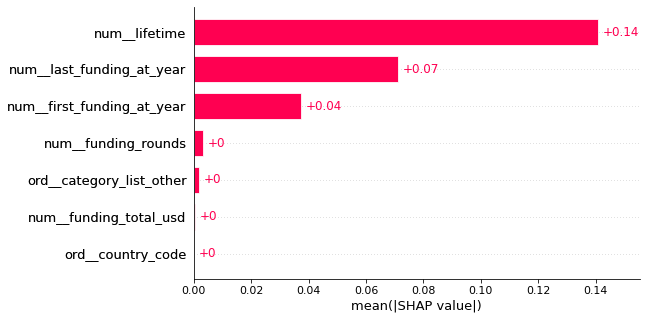

In [140]:
X_train_preprocessed_smpl = shap.sample(X_train_prep, 60, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_prep, 60, random_state=RANDOM_STATE)


explainer = shap.KernelExplainer(model.predict_proba, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

explanation = shap.Explanation(values=shap_values[:, :, 1],
                               base_values=explainer.expected_value,
                               data=X_test_preprocessed_smpl)

explanation2 = shap.Explanation(
    values=explanation.values, 
    base_values=explanation.base_values, 
    data=explanation.data, 
    feature_names=explainer.data_feature_names
)

shap.plots.bar(explanation2, max_display=17)

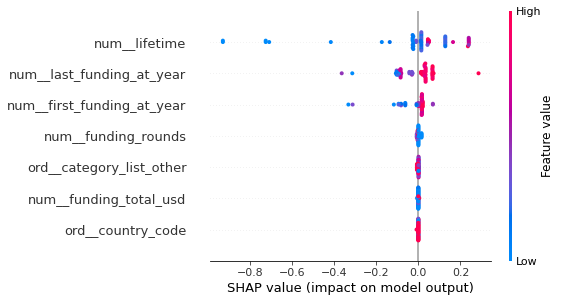

In [141]:
shap.summary_plot(explanation)

/opt/conda/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=18 is greater than n_features=7. All the features will be returned.
  warnings.warn(


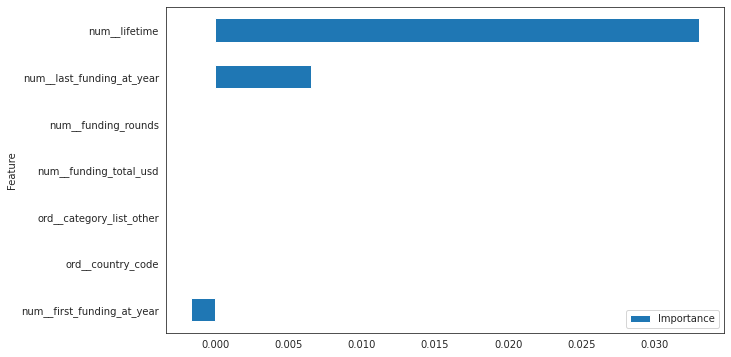

In [142]:
selector3 = SelectKBest(mutual_info_classif, k=18)
selector3.fit(X_train_prep, y_train)
features_names3 = selector3.get_feature_names_out()
per = permutation_importance(model, X_test_prep, y_test, scoring=['f1'])

feature_importance = pd.DataFrame({'Feature': features_names3, 'Importance': per['f1']['importances_mean']})
#print(feature_importance)
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')

feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

`Вывод:`  *Ни категория, ни страна не влияют на закрытие стартапа, только срок жизни и дала последнего раунда. Чем дольше срок жизни, тем больше шансов, что стартап будет жить. Рекомендация владельцам компаний - держаться как можно дольше, и скорее всего стартап вообще не закроется. Также год последнего раунда имеет значение, чем позже последний раунд, тем больше шансов для жизни стартапа. Рекомендауия - пусть последний раунд будет как можно позже. Рекомендации вполне обычные и очевидные.*

## Прогноз на лучшей модели.

Лучшая модель, показавшая лучшую метрику на тестовых данных - модель LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear') на с OneHot кодированием.

Сделаем прогноз.

In [143]:
X_test

,funding_total_usd,country_code,funding_rounds,lifetime,first_funding_at_year,last_funding_at_year,category_list_other
0,2819200.0,NIC,1,3501,2009,2009,clean technology
1,0.0,USA,1,2717,2010,2010,hospitality
2,428257.0,LUX,2,1295,2014,2014,finance
3,34700000.0,USA,4,4748,2005,2010,software
4,4530000.0,CAN,1,6209,2007,2007,software
...,...,...,...,...,...,...,...
13116,28000.0,USA,1,2267,2012,2012,recruiting
13117,0.0,USA,1,2192,2013,2013,software
13118,5600000.0,USA,3,2922,2008,2011,design
13119,150000.0,USA,2,1386,2014,2014,other


In [144]:
predictions = randomized_search_ohe.predict(X_test)
pred = pd.DataFrame(zip(test['name'], predictions), columns = ['name','predicted_status_1'])
pred

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,name,predicted_status_1
0,crystalsol,1
1,jbi fish & wings,1
2,coinplus,1
3,imagine communications,1
4,dna13,1
...,...,...
13116,jymob,1
13117,globatrek,1
13118,inkd.com,1
13119,adwill,1


In [145]:
pred['predicted_status'] = pred['predicted_status_1'].apply(lambda x: "operating" if x == 1 else 'closed')
pred = pred.drop('predicted_status_1', axis=1)
pred.sample(5)

,name,predicted_status
2622,acer,operating
11102,poplar level player's plaza,operating
503,plutio,operating
2145,more.com,operating
10969,sunlight financial,operating


In [146]:
pred['predicted_status'].value_counts()


operating    12282
closed         839
Name: predicted_status, dtype: int64

`Вывод: `В таблице pred предсказания на тестовых данных для этой модели.12 тыс. стратапов открыты.

## Вывод.

ВЫВОД:
Для создания модели предсказания закрытия стратапов были получены три таблицы с объектными, временными и числовыми типами данных: отдельно тренировочные данные и две таблицы тестовые с разными столбцами.
Данные прошли предобработку. Время было сохранено в формате года дат. Частично устранены пропуски. Значительно сокращено количество классов в «категориях стратапов»: с 22 105 до 231. В тренировочную выборку добавлен столбец «время жизни», такой столбец есть в тестовых данных. Удалены дубликаты. Тестовая таблица объединена с предсказаниями. 
Исследование показало, что распределение тестовых данных и категориальных похожи, разрыв между численностью данных в категориях небольшой. Основная часть компаний финансировалась от 0 до 200 тыс. долларов. Есть выбросы.
По категориям тестовая и тренировочная данные также распределены похожим образом. Привалирует США — 73 %. Изменение баланса компаний из США не повлияло на улучшение метрики. Количество стран 134 и 96  в тренировочной и тестовой выборках соответственной.
Также одинаково распределены компании в обеих выборках по количеству раундов, 63-64 процента компаний прошли только один раунд. Соответственно в датах первого и последнего раундов похожие данные: основная часть раундов проходила в 2012-2015 гг. Этим оба набора данных похожи.
Срок жизни стартапов в основном 7 лет. Но в этих данных также есть многочисленные выбросы в сторону увеличения срока. 
Целевая переменная «статус» находится в дисбалансе в тренировочной выборке, т. е. 91 стартапов открыты. Но в тестовой выборке компаний открытых и закрытых почти поровну.
Корреляционный анализ показал, что мультиколлинеарноость есть только между первым и последним раундами. Утечки данных нет.
Подготовили целевой признак. Сформировали тренировочную и валидационную выборки из тренировочных данных. В паплйне закодировали данные и перебором параметров RandomizedSearchCV нашли лучшую модель — дерево решений. Но модель переобучилась, т. к. показала высокую метрику F1, на тренировочных и валидационных данных и среднюю метрику, 0,65, на тестовых данных. 
Также применили Undersampling, полиномизацию признаков, кодирование OneHot  вместо OneEncoder. Расширение количества моделей в паплайне добавлением SVC. Метрику на тестовых данных улучшила лишь до 0,66 кодирование OneHot.
Анализ признаков показал факторы, влияющие на открытие/закрытие: срок жизни стартапа и год последнего раунда.
Был создан прогноз на лучшей модели в виде таблицы.
